In [1]:
# import tensorflow as tf

# print(tf.__version__)

In [2]:
# import os
# os.environ.get("tf_upgrade_v2")

In [3]:
# !tf_upgrade_v2 \
#   --infile /home/hcxia/TradeMaster_dev/TradeMaster/data_synthesis/TimeGAN/timegan.py \
#   --outfile /home/hcxia/TradeMaster_dev/TradeMaster/data_synthesis/TimeGAN/timegan_v2_new.py \
#   --reportfile report.txt

In [4]:
# import tensorflow as tf

# print(tf.__version__)

In [5]:
# import os
# os.environ.get("tf_upgrade_v2")

# TimeGAN Tutorial

## Time-series Generative Adversarial Networks

- Paper: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

- Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

- Last updated Date: April 24th 2020

- Code author: Jinsung Yoon (jsyoon0823@gmail.com)

This notebook describes the user-guide of a time-series synthetic data generation application using timeGAN framework. We use Stock, Energy, and Sine dataset as examples.

### Prerequisite
Clone https://github.com/jsyoon0823/timeGAN.git to the current directory.

## Necessary packages and functions call

- timegan: Synthetic time-series data generation module
- data_loading: 2 real datasets and 1 synthetic datasets loading and preprocessing
- metrics: 
    - discriminative_metrics: classify real data from synthetic data
    - predictive_metrics: train on synthetic, test on real
    - visualization: PCA and tSNE analyses

In [6]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from style_timegan import styletimegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization
import pandas as pd
from tqdm import tqdm
import pickle

In [7]:
def get_intervals(data):
    index=data['index']
    last_value=index[0]-1
    last_index=0
    intervals=[]
    for i in range(data.shape[0]):
        if last_value!=index[i]-1:
            intervals.append([last_index,i])
            last_value=index[i]
            last_index=i
        last_value=index[i]
    intervals.append([last_index, i])
    return intervals

In [8]:
def interpolation(data):
    max_len=24
    l=len(data)
    to_fill=max_len-l
    if to_fill!=0:
        interval=max_len//to_fill
        for j in range(to_fill):
            idx=(interval+1)*j+interval
            data.insert(min(idx,len(data)-1),float('nan'))
    data=pd.Series(data).interpolate(method='polynomial', order=2)
    return data

In [9]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    norm_data = numerator / (denominator + 1e-7)
    return np.min(data, 0),np.max(data, 0),norm_data

In [10]:
def minmax_normlization(data):
    normalized_data=(data-data.min())/(data.max()-data.min())
    return normalized_data

In [11]:
def get_data_of_same_length(data,seq_len):
    data_processed=[]
    intervals=get_intervals(data)
    temp_data=[]
    data.drop(columns=['index'])
    for interval in intervals:
#         print(interval)
        data_seg=data.iloc[interval[0]:interval[1],:]
        for i in range(0, len(data_seg) - seq_len):
            _x = data_seg.iloc[i:i + seq_len,:]
            temp_data.append(_x)
    return temp_data

# Run through

In [12]:
def dataset_prepareation(path):
    data=pd.read_csv(path).reset_index()
    tics=data['tic'].unique()
    # features=[ 'open', 'high', 'low', 'close', 'adjcp','zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10',
    #    'zd_15', 'zd_20', 'zd_25', 'zd_30', 'pct_return', 'adjcp_filtered',
    #    'pct_return_filtered','volume']
    features=['open','high','low','close','adjcp','volume']
    ret=[]
    for col in data.columns:
        if col in features:
            ret.append(col)
    features=ret
    min_sclar_by_tic={}
    max_sclar_by_tic={}
    for tic in tics:
        data_by_tic=data.loc[data['tic']==tic,features].astype(float)
        min_scalr,max_sclar,norm_data_by_tic=MinMaxScaler(data_by_tic)
        # print(min_scalr.shape)
        data.loc[data['tic']==tic,features]=norm_data_by_tic
        min_sclar_by_tic[tic]=min_scalr
        max_sclar_by_tic[tic]=max_sclar
    stock_group_num=len(data['stock_type'].unique())
    regime_num=len(data['label'].unique())
    for tic in tics:
        with open('./data/scalr/'+str(tic)+'_minsclar'+'.pickle', 'wb') as handle:
            pickle.dump(min_sclar_by_tic[tic], handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('./data/scalr/'+str(tic)+'_maxsclar'+'.pickle', 'wb') as handle:
            pickle.dump(max_sclar_by_tic[tic], handle, protocol=pickle.HIGHEST_PROTOCOL)
        for j in range(regime_num):
            data_seg=data.loc[(data['tic']==tic) & (data['label']==j),['index','open','high','low','close','adjcp','volume']]
    #         data_dict[(i,j)]=data_seg
            data_seg.to_csv('./data/data_seg_'+tic+'_'+str(j)+'.csv')
        

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [13]:
# data=pd.read_csv('/home/hcxia/TradeMaster_dev/TradeMaster/data_synthesis/TimeGAN/GOOG_labeled_3_24.csv').reset_index()

In [14]:
# data=pd.read_csv("./DJI_all_labeled_3_24.csv").reset_index()

In [15]:
# dataset_prepareation("/home/hcxia/TradeMaster_dev/TradeMaster/data/data/other/DJI_all_labeled_3_24.csv")

In [16]:
# dataset_prepareation('/home/hcxia/TradeMaster_dev/TradeMaster/data/data/other/GOOG_labeled_3_24.csv')

# preprocess data by stock group and regime

Normalize features with in own tic

# Make data dict

In [17]:
def prepare_data_for_trainning(path,label,label_number=3):
    data=pd.read_csv(path).drop('index', axis=1)
    data=data.reset_index().rename(columns={data.index.name:'index'})
#     plt.plot(data['adjcp'])
#     plt.show()
#     display(data.head())
    data.to_csv('temp_data.csv')
    data=get_data_of_same_length(data,24)
#     for i in range(20):
#         plt.plot(data[i]['adjcp'])
#         plt.show()
#         print(i)
#         display(data[i])
#     display(len(data))
    data_res=[]
    label_res=[]
    for d in data:
        data_res.append(d.loc[:,['open','high','low','close','adjcp','volume']].to_numpy())
        label_temp=np.zeros(label_number)
        label_temp[label]=1
        label_res.append(label_temp)
    return data_res,label_res

### GOOG data

In [18]:
GOOG_data={}
GOOG_data_label={}
for i in range(3):
    GOOG_data['data_seg_GOOG_'+str(i)],GOOG_data_label['data_seg_GOOG_'+str(i)]=prepare_data_for_trainning('./data/data_seg_GOOG_'+str(i)+'.csv',i)
    print(i,len(GOOG_data['data_seg_GOOG_'+str(i)]))

0 673
1 1591
2 1529


### Single stock data

In [19]:
data=pd.read_csv("/home/hcxia/TradeMaster_dev/TradeMaster/data/data/other/DJI_all_labeled_3_24.csv").reset_index()
tics=data['tic'].unique()
data_dict_tic={}
data_dict_tic_label={}
for tic in tics:
    data_dict_tic[tic]={}
    data_dict_tic_label[tic]={}
    for i in range(3):
        data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)],data_dict_tic_label[tic]['data_seg_'+str(tic)+'_'+str(i)]=prepare_data_for_trainning('./data/data_seg_'+str(tic)+'_'+str(i)+'.csv',i)
        print(tic,i,len(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)]))

AAPL 0 1147
AAPL 1 1982
AAPL 2 2583
CSCO 0 1208
CSCO 1 2707
CSCO 2 1797
TRV 0 867
TRV 1 3239
TRV 2 1606
CAT 0 1319
CAT 1 2117
CAT 2 2276
UNH 0 647
UNH 1 2939
UNH 2 2126
BA 0 1332
BA 1 2362
BA 2 2018
VZ 0 886
VZ 1 3713
VZ 2 1113
CVX 0 840
CVX 1 3201
CVX 2 1671
PG 0 460
PG 1 4131
PG 2 1121
HD 0 1094
HD 1 2645
HD 2 1973
GS 0 1140
GS 1 2737
GS 2 1835
MSFT 0 956
MSFT 1 3130
MSFT 2 1626
DIS 0 954
DIS 1 3054
DIS 2 1704
NKE 0 967
NKE 1 2592
NKE 2 2153
HON 0 904
HON 1 3137
HON 2 1671
MMM 0 813
MMM 1 3439
MMM 2 1460
INTC 0 1363
INTC 1 2440
INTC 2 1909
KO 0 394
KO 1 4438
KO 2 880
JNJ 0 290
JNJ 1 4546
JNJ 2 876
JPM 0 1099
JPM 1 2731
JPM 2 1882
IBM 0 940
IBM 1 3272
IBM 2 1500
MCD 0 714
MCD 1 3668
MCD 2 1330
WBA 0 948
WBA 1 3243
WBA 2 1521
AXP 0 1003
AXP 1 3140
AXP 2 1569
MRK 0 1015
MRK 1 3193
MRK 2 1504
WMT 0 695
WMT 1 3919
WMT 2 1098
AMGN 0 1051
AMGN 1 3073
AMGN 2 1588


### Stock group data

In [20]:
data=pd.read_csv("/home/hcxia/TradeMaster_dev/TradeMaster/data/data/other/DJI_all_labeled_3_24.csv").reset_index()
# display(data.columns)
tic_group_pair=data.loc[:,['tic','stock_type']]
tic_group_pair=tic_group_pair.groupby(['tic','stock_type']).size().reset_index(name='Freq')
stock_group_num=len(data['stock_type'].unique())
tic_in_group={}
for group in range(stock_group_num):
#     if group not in tic_in_group：
#         tic_in_group[group]=[]
    tic_in_group[group]=list(tic_group_pair.loc[tic_group_pair['stock_type']==group,:]['tic'].unique())

In [21]:
print(tic_in_group)

{0: ['BA', 'HD', 'MSFT', 'UNH'], 1: ['AXP', 'DIS', 'JPM', 'PG', 'WMT'], 2: ['AAPL', 'NKE'], 3: ['AMGN', 'CAT', 'CVX', 'HON', 'IBM', 'JNJ', 'MCD', 'MMM', 'TRV'], 4: ['CSCO', 'INTC', 'KO', 'MRK', 'VZ', 'WBA'], 5: ['GS']}


In [22]:
data=pd.read_csv("/home/hcxia/TradeMaster_dev/TradeMaster/data/data/other/DJI_all_labeled_3_24.csv").reset_index()
stock_group_num=len(data['stock_type'].unique())
data_dict_group={}
data_dict_group_label={}
for group in range(stock_group_num):
    data_dict_group[group]={}
    data_dict_group_label[group]={}
    for i in range(3):
        if 'data_seg_'+str(group)+'_'+str(i) not in data_dict_group[group]:
            data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)]=[]
            data_dict_group_label[group]['data_seg_'+str(group)+'_'+str(i)]=[]
        for tic in tic_in_group[group]:
            data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)].extend(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)])
            data_dict_group_label[group]['data_seg_'+str(group)+'_'+str(i)].extend(data_dict_tic_label[tic]['data_seg_'+str(tic)+'_'+str(i)])
        print(group,i,len(data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)]))

0 0 4029
0 1 11076
0 2 7743
1 0 4211
1 1 16975
1 2 7374
2 0 2114
2 1 4574
2 2 4736
3 0 7738
3 1 29692
3 2 13978
4 0 5814
4 1 19734
4 2 8724
5 0 1140
5 1 2737
5 2 1835


### All dji stock data

In [23]:
data_all={}
data_all_label={}
for i in range(3):
    if 'data_seg_'+'all'+'_'+str(i) not in data_all:
        data_all['data_seg_'+'all'+'_'+str(i)]=[]
        data_all_label['data_seg_'+'all'+'_'+str(i)]=[]
    for tic in tics:
        data_all['data_seg_'+'all'+'_'+str(i)].extend(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)])
        data_all_label['data_seg_'+'all'+'_'+str(i)].extend(data_dict_tic_label[tic]['data_seg_'+str(tic)+'_'+str(i)])
    print(i,len(data_all['data_seg_'+'all'+'_'+str(i)]))

0 25046
1 84788
2 44390


# Style Training dataset

In [24]:
style_training_data=[]
style_training_label=[]
for i in range(3):
    style_training_data.extend(data_all['data_seg_'+'all'+'_'+str(i)])
    style_training_label.extend(data_all_label['data_seg_'+'all'+'_'+str(i)])

## Training helper

# data set:

- GOOG_data
- data_dict_tic (dict of dict by tic)
- data_dict_group (dict of dict by group num)
- data_all

## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [25]:
print(GOOG_data.keys())
print(data_dict_tic.keys())
print(data_dict_group.keys())
print(data_all.keys())

dict_keys(['data_seg_GOOG_0', 'data_seg_GOOG_1', 'data_seg_GOOG_2'])
dict_keys(['AAPL', 'CSCO', 'TRV', 'CAT', 'UNH', 'BA', 'VZ', 'CVX', 'PG', 'HD', 'GS', 'MSFT', 'DIS', 'NKE', 'HON', 'MMM', 'INTC', 'KO', 'JNJ', 'JPM', 'IBM', 'MCD', 'WBA', 'AXP', 'MRK', 'WMT', 'AMGN'])
dict_keys([0, 1, 2, 3, 4, 5])
dict_keys(['data_seg_all_0', 'data_seg_all_1', 'data_seg_all_2'])


In [26]:
def training(data_set_dict,label_set_dict,style_training_data,style_training_label,style_training=True,only_style_training=False,from_join_training=False):
    parameters = dict()
    parameters['module'] = 'gru' 
    parameters['hidden_dim'] = 24
    parameters['num_layer'] = 3
    parameters['iterations'] = 10000
    parameters['batch_size'] = 128
    gnerated_dataset_dict={}
    for dataset_name, data_set in data_set_dict.items():
        print(str(dataset_name))
        label=int(dataset_name[-1])
        print(label)
        # styletimegan(ori_data, parameters,training_label,nb_classes,label,style_training_data,style_training=True,only_style_training=False,save_name=None,from_join_training=False):
        gnerated_dataset_dict[dataset_name] = styletimegan(ori_data=data_set,
                                                           parameters=parameters,
                                                           training_label=style_training_label,
                                                           save_name=str(dataset_name),
                                                           label=label_set_dict[dataset_name],
                                                          nb_classes=3,
                                                          style_training_data=style_training_data,
                                                          style_training=style_training,
                                                          only_style_training=only_style_training,
                                                           from_join_training=from_join_training
                                                          )
        if only_style_training:
            break
    return gnerated_dataset_dict

In [27]:
import importlib
# importlib.reload(styletimegan)
%load_ext autoreload
%autoreload 2

In [28]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [29]:
import torch
torch.cuda.device_count()

4

# Style discrimiator Pre-train

In [30]:
# def training(data_set_dict,label_set_dict,style_training_data,style_training_label,style_training=True,only_style_training=False,from_join_training=False):

In [32]:

# print(tf.__version__)

In [52]:
GOOG_data_generated=training(data_set_dict=GOOG_data,
                             label_set_dict=GOOG_data_label,
                             style_training_data=style_training_data,
                             style_training_label=style_training_label,
                             style_training=True,
                             only_style_training=True,
                             from_join_training=False
                            )

data_seg_GOOG_0
0
(?, 24, 128)
(?, 128)
(?, 3)
L_x_style_training (?, 3)
(?, 24, 128)
(?, 128)
(?, 3)
style_L (?, 3)


2023-01-16 23:13:24.711941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-16 23:13:24.711967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


start style training
itt: 0 step_style_loss: 0.76136285
step: 0/10000, style_loss: 0.8726
itt: 100 step_style_loss: 0.7592271
itt: 200 step_style_loss: 0.7123521
itt: 300 step_style_loss: 0.7383938
itt: 400 step_style_loss: 0.7123521
itt: 500 step_style_loss: 0.7071438
itt: 600 step_style_loss: 0.7436021
itt: 700 step_style_loss: 0.7071438
itt: 800 step_style_loss: 0.6915187
itt: 900 step_style_loss: 0.6811021
itt: 1000 step_style_loss: 0.7279771
step: 1000/10000, style_loss: 0.8532
itt: 1100 step_style_loss: 0.7279771
itt: 1200 step_style_loss: 0.71756047
itt: 1300 step_style_loss: 0.70193547
itt: 1400 step_style_loss: 0.7279771
itt: 1500 step_style_loss: 0.71756047
itt: 1600 step_style_loss: 0.7227688
itt: 1700 step_style_loss: 0.6967271
itt: 1800 step_style_loss: 0.71756047
itt: 1900 step_style_loss: 0.71756047
itt: 2000 step_style_loss: 0.6915188
step: 2000/10000, style_loss: 0.8316
itt: 2100 step_style_loss: 0.6915188
itt: 2200 step_style_loss: 0.68631047
itt: 2300 step_style_loss

KeyboardInterrupt: 

# Training 

In [29]:
GOOG_data_generated=training(GOOG_data)

data_seg_GOOG_0
0


TypeError: styletimegan() got an unexpected keyword argument 'device'

In [ ]:
data_dict_tic_generated={}
for tic in data_dict_tic.keys():
    if tic not in data_dict_tic_generated:
        data_dict_tic_generated[tic]=training(data_dict_tic[tic])

In [ ]:
data_dict_tic_APPL_generated=training(data_dict_tic['AAPL'])
data_dict_group_3_generated=training(data_dict_group[3])
GOOG_data_generated=training(GOOG_data)
data_all_generated=training(data_all)

In [ ]:
data_dict_group_4_generated=training(data_dict_group[4])

## Save generated data

In [71]:
data_to_save=[
data_dict_tic_APPL_generated,
data_dict_group_3_generated,
GOOG_data_generated,
data_all_generated,
data_dict_group_4_generated
]
for tic in data_dict_tic_generated.keys():
    locals()['data_dict_tic_'+tic+'_generated']=data_dict_tic_generated[tic]
    data_to_save.append(locals()['data_dict_tic_'+tic+'_generated'])

In [72]:
import pickle
import inspect


def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]
for i in range(len(data_to_save)):
    try:
        with open('./generated_data/'+retrieve_name(data_to_save[i])[-1]+'.pickle', 'wb') as handle:
            pickle.dump(data_to_save[i], handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('writen to '+retrieve_name(data_to_save[i])[-1]+'.pickle')
    except:
        print('skip this')

writen to data_dict_tic_APPL_generated.pickle
writen to data_dict_group_3_generated.pickle
writen to GOOG_data_generated.pickle
writen to data_all_generated.pickle
writen to data_dict_group_4_generated.pickle
writen to data_dict_tic_AAPL_generated.pickle
writen to data_dict_tic_CSCO_generated.pickle
writen to data_dict_tic_TRV_generated.pickle
writen to data_dict_tic_CAT_generated.pickle
writen to data_dict_tic_UNH_generated.pickle
writen to data_dict_tic_BA_generated.pickle
writen to data_dict_tic_VZ_generated.pickle
writen to data_dict_tic_CVX_generated.pickle
writen to data_dict_tic_PG_generated.pickle


## Evaluate the generated data



In [ ]:
def dis_score(ori_data, generated_data):
    metric_iteration = 5
    discriminative_score = list()
    for _ in range(metric_iteration):
        temp_disc = discriminative_score_metrics(ori_data, generated_data)
        discriminative_score.append(temp_disc)
    print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))
    return np.round(np.mean(discriminative_score), 4)

def pred_score(ori_data, generated_data):
    predictive_score = list()
    metric_iteration = 5
    for tt in range(metric_iteration):
        temp_pred = predictive_score_metrics(ori_data, generated_data)
        predictive_score.append(temp_pred)   
    print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))
    return np.round(np.mean(predictive_score), 4)
    
def evaluation(data_set_dict,genrated_data_set_dict):
    length_dict={}
    discriminative_score_dict={}
    predictive_score_dict={}
    for dataset_name, data_set in data_set_dict.items():
        length_dict[dataset_name]=len(data_set_dict[dataset_name])
        discriminative_score_dict[dataset_name] = dis_score(data_set_dict[dataset_name],genrated_data_set_dict[dataset_name])
        predictive_score_dict[dataset_name] = pred_score(data_set_dict[dataset_name],genrated_data_set_dict[dataset_name])
        visualization(data_set_dict[dataset_name],genrated_data_set_dict[dataset_name], 'pca')
        visualization(data_set_dict[dataset_name],genrated_data_set_dict[dataset_name], 'tsne')
    return length_dict,discriminative_score_dict,predictive_score_dict

2023-01-13 14:12:08.169382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:12:08.169408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:12:19.400635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:12:19.400657: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:12:30.345695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:12:30.345717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:12:41.013872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:12:41.013900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:12:51.765181: I tensorflow

Discriminative score: 0.1991


2023-01-13 14:13:02.415953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:13:02.415975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:13:28.542283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:13:28.542306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:13:56.607287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:13:56.607311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:14:23.766874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:14:23.766894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:14:49.397430: I tensorflow

Predictive score: 0.0382


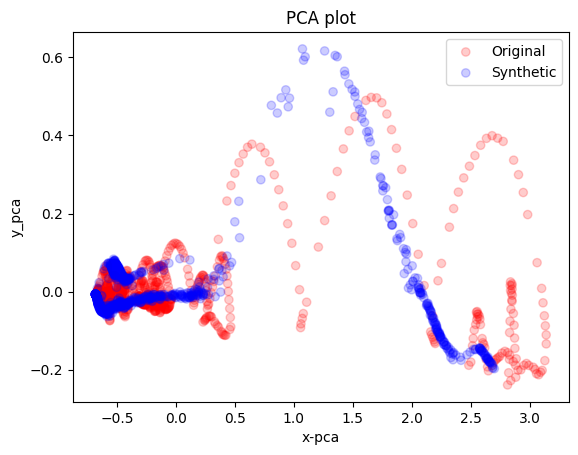

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.013026
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.485188
[t-SNE] KL divergence after 300 iterations: 0.672063


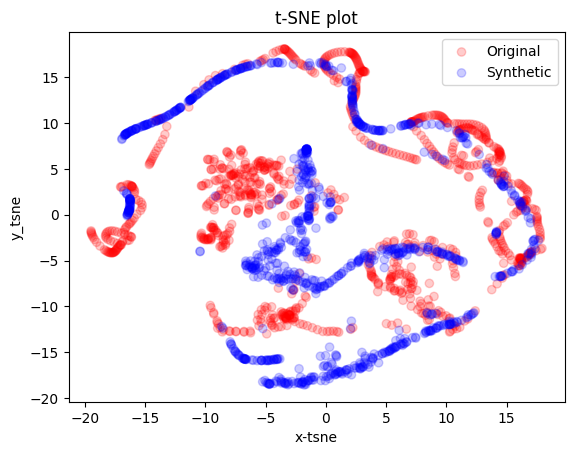

2023-01-13 14:15:18.791555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:15:18.791577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:15:30.017989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:15:30.018015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:15:41.196927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:15:41.196950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:15:52.198440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:15:52.198464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:16:03.306631: I tensorflow

Discriminative score: 0.1877


2023-01-13 14:16:14.324982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:16:14.325003: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:16:42.022074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:16:42.022101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:17:09.331198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:17:09.331224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:17:37.957256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:17:37.957278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:18:04.232569: I tensorflow

Predictive score: 0.0277


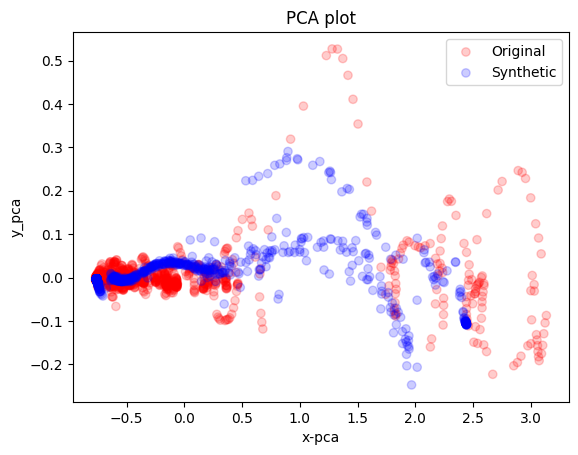

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.002597
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.537628
[t-SNE] KL divergence after 300 iterations: 0.675974


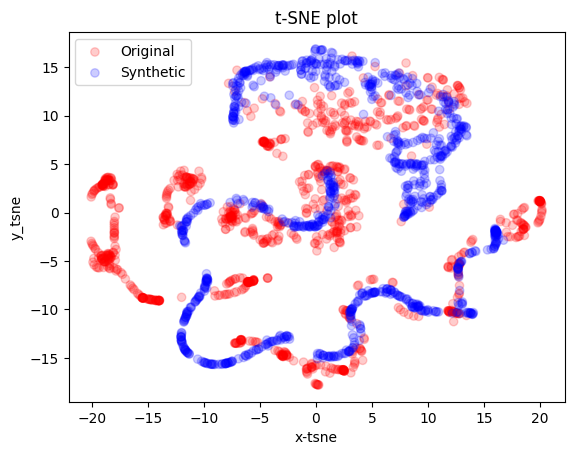

2023-01-13 14:18:33.475605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:18:33.475628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:18:44.674481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:18:44.674500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:18:55.771603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:18:55.771627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:19:06.971393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:19:06.971415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:19:18.764339: I tensorflow

Discriminative score: 0.142


2023-01-13 14:19:30.116100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:19:30.116125: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:19:58.083113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:19:58.083135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:20:25.556317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:20:25.556342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:20:52.895534: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:20:52.895563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:21:20.632554: I tensorflow

Predictive score: 0.0265


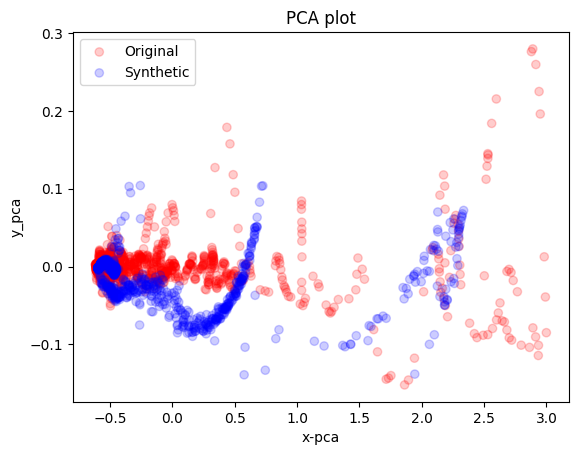

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.004846
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.087765
[t-SNE] KL divergence after 300 iterations: 0.678166


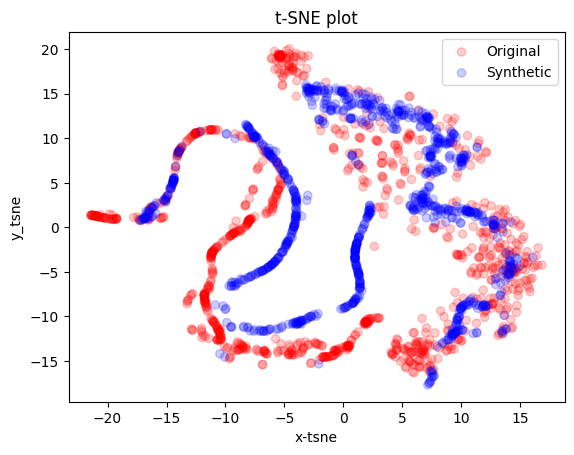

2023-01-13 14:21:48.548594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:21:48.548620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:21:59.865906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:21:59.865930: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:22:11.511907: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:22:11.511934: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:22:22.991937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:22:22.991961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:22:34.049096: I tensorflow

Discriminative score: 0.1909


2023-01-13 14:22:45.151156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:22:45.151178: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:23:13.488986: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:23:13.489015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:23:40.687780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:23:40.687810: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:24:08.192420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:24:08.192448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:24:33.416487: I tensorflow

Predictive score: 0.0372


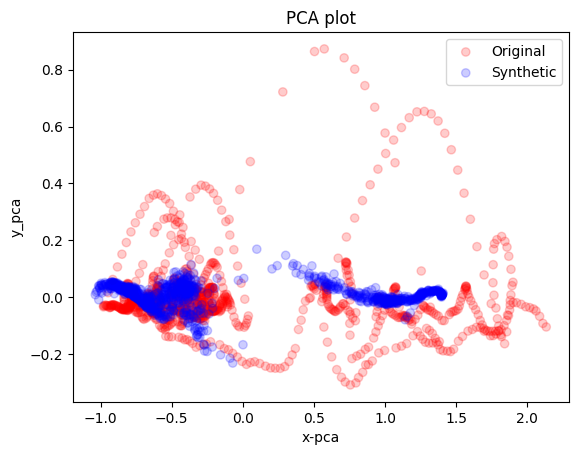

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.038460
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.516598
[t-SNE] KL divergence after 300 iterations: 0.809367


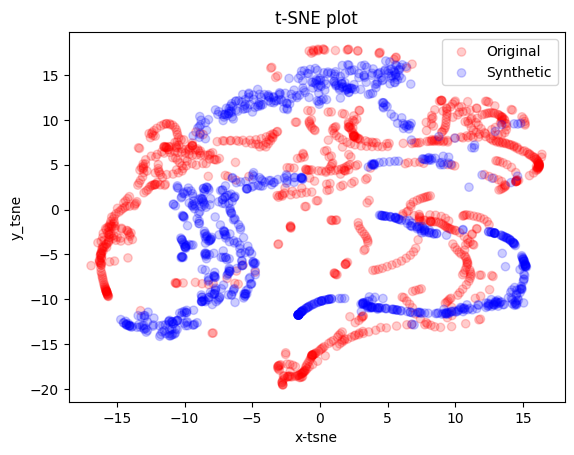

2023-01-13 14:25:02.072460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:25:02.072485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:25:13.652846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:25:13.652871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:25:24.951490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:25:24.951510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:25:36.616831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:25:36.616858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:25:48.542752: I tensorflow

Discriminative score: 0.1601


2023-01-13 14:25:59.542919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:25:59.542946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:26:26.739390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:26:26.739419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:26:55.380762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:26:55.380787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:27:23.111799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:27:23.111829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:27:50.576599: I tensorflow

Predictive score: 0.0275


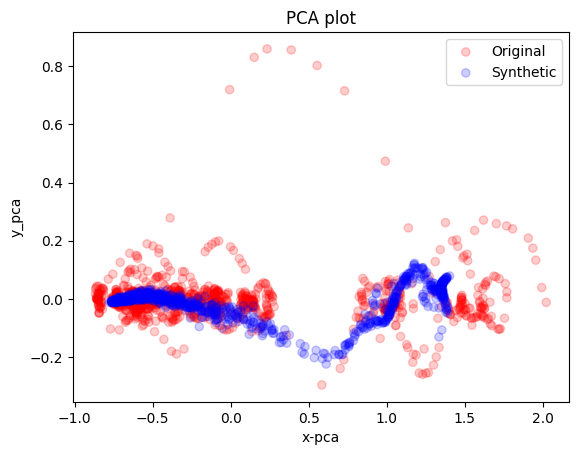

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.018476
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.044270
[t-SNE] KL divergence after 300 iterations: 0.700919


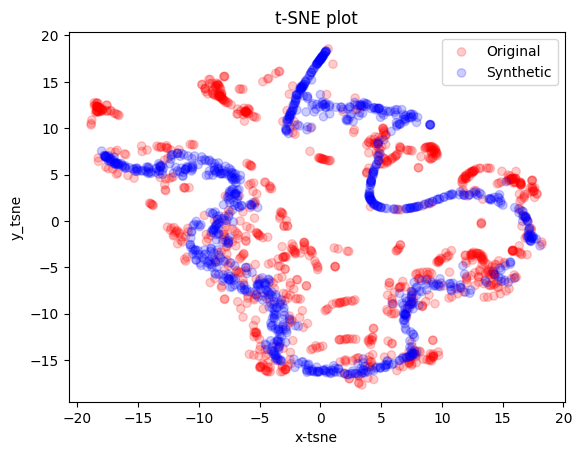

2023-01-13 14:28:21.521509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:28:21.521533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:28:32.959381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:28:32.959401: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:28:44.069253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:28:44.069280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:28:55.540702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:28:55.540728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:29:06.616432: I tensorflow

Discriminative score: 0.1839


2023-01-13 14:29:17.996140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:29:17.996168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:29:45.042907: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:29:45.042933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:30:12.573366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:30:12.573392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:30:39.650664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:30:39.650689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:31:06.250212: I tensorflow

Predictive score: 0.0269


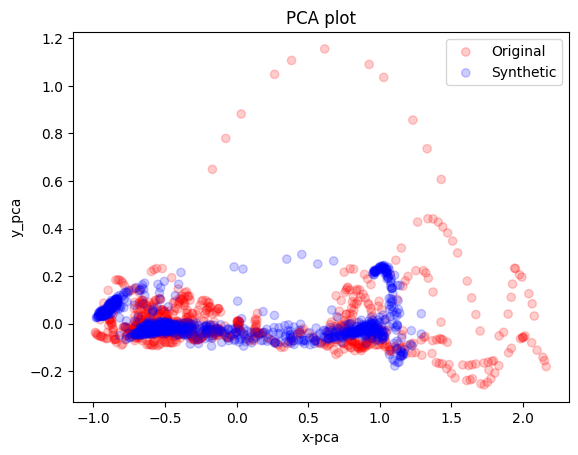

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.032490
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.342983
[t-SNE] KL divergence after 300 iterations: 0.729352


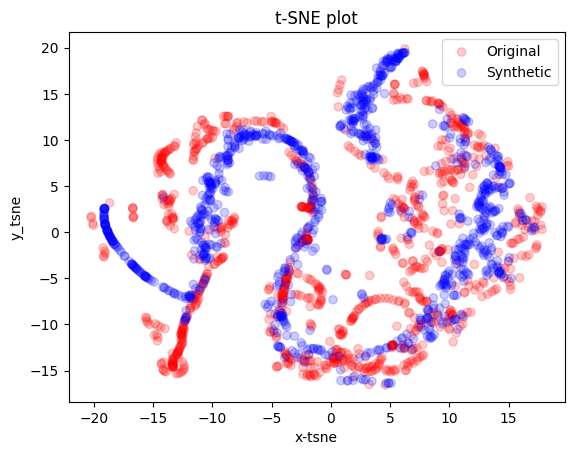

2023-01-13 14:31:36.468193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:31:36.468218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:31:47.379680: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:31:47.379702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:31:58.526939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:31:58.526964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:32:09.412417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:32:09.412439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:32:20.838168: I tensorflow

Discriminative score: 0.1397


2023-01-13 14:32:31.970647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:32:31.970668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:32:59.611746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:32:59.611765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:33:26.855959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:33:26.855987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:33:53.848660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:33:53.848677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:34:21.015216: I tensorflow

Predictive score: 0.0504


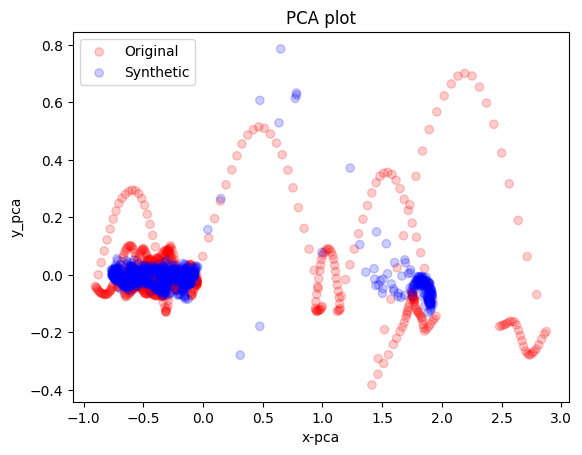

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1734 samples in 0.000s...
[t-SNE] Computed neighbors for 1734 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1734
[t-SNE] Computed conditional probabilities for sample 1734 / 1734
[t-SNE] Mean sigma: 0.030162
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.340233
[t-SNE] KL divergence after 300 iterations: 0.729805


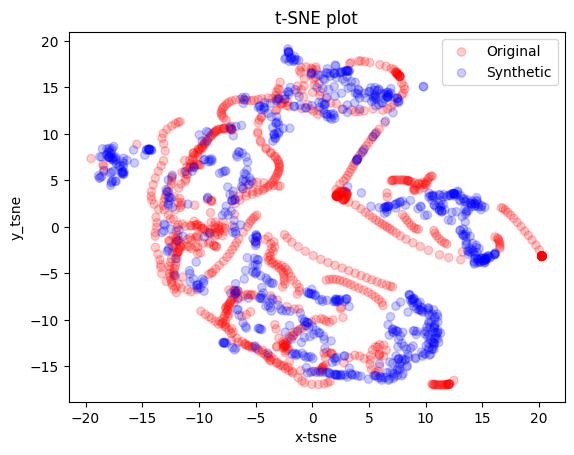

2023-01-13 14:34:50.269441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:34:50.269469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:35:01.436376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:35:01.436398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:35:13.112968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:35:13.112989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:35:24.145588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:35:24.145633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:35:35.312535: I tensorflow

Discriminative score: 0.1344


2023-01-13 14:35:46.727521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:35:46.727542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:36:14.645814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:36:14.645844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:36:43.472140: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:36:43.472160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:37:12.558628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:37:12.558650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:37:40.036987: I tensorflow

Predictive score: 0.0313


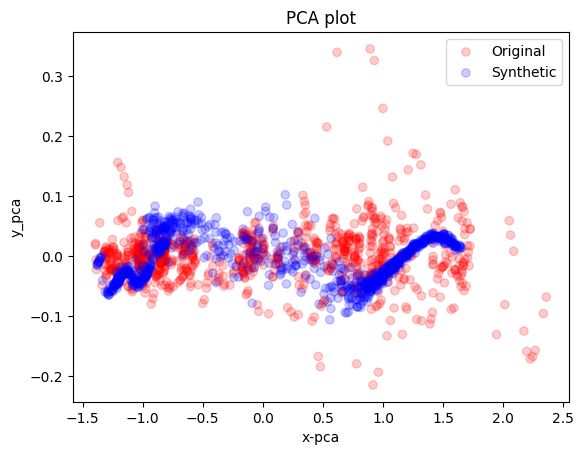

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.030126
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.924549
[t-SNE] KL divergence after 300 iterations: 0.623825


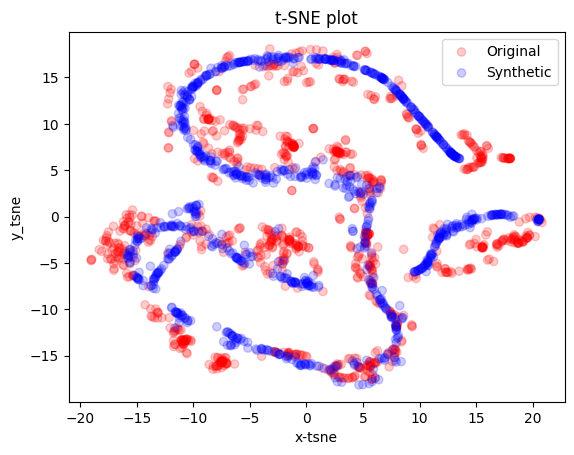

2023-01-13 14:38:09.077196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:38:09.077217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:38:20.499258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:38:20.499276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:38:32.380863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:38:32.380885: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:38:44.003880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:38:44.003908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:38:55.473496: I tensorflow

Discriminative score: 0.1161


2023-01-13 14:39:06.939210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:39:06.939234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:39:34.650049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:39:34.650072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:39:59.532723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:39:59.532750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:40:27.428894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:40:27.428915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:40:53.574900: I tensorflow

Predictive score: 0.0454


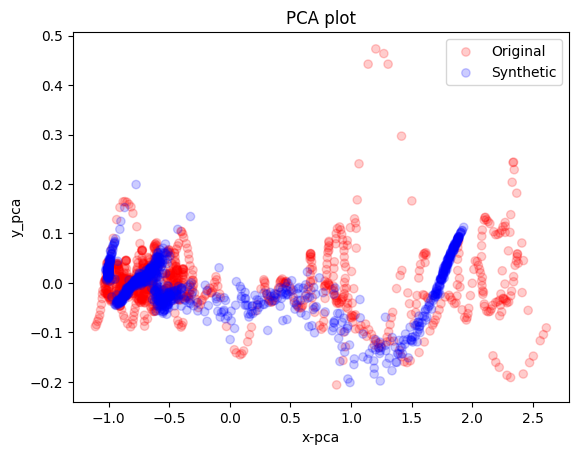

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.021915
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.489937
[t-SNE] KL divergence after 300 iterations: 0.740832


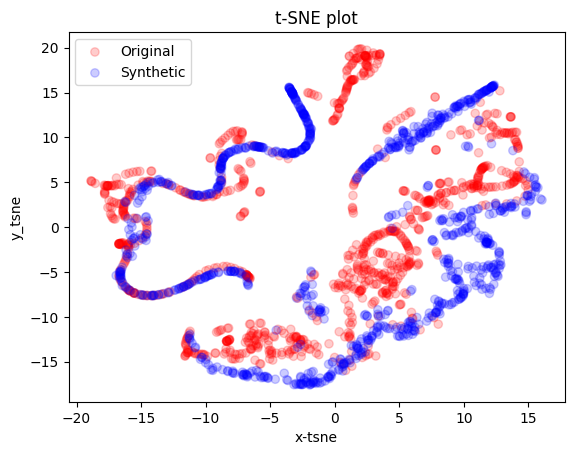

2023-01-13 14:41:22.839489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:41:22.839520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:41:34.399682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:41:34.399709: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:41:45.783452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:41:45.783475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:41:57.367851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:41:57.367870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:42:08.407761: I tensorflow

Discriminative score: 0.1902


2023-01-13 14:42:19.454602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:42:19.454628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:42:46.746068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:42:46.746091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:43:14.861572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:43:14.861591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:43:43.256640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:43:43.256663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:44:11.708077: I tensorflow

Predictive score: 0.0421


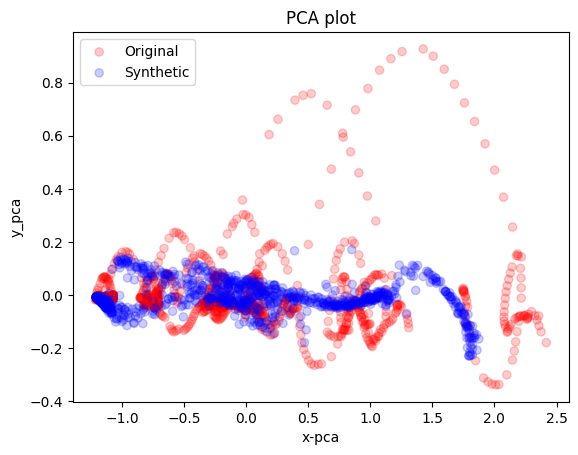

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.020233
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.970207
[t-SNE] KL divergence after 300 iterations: 0.696825


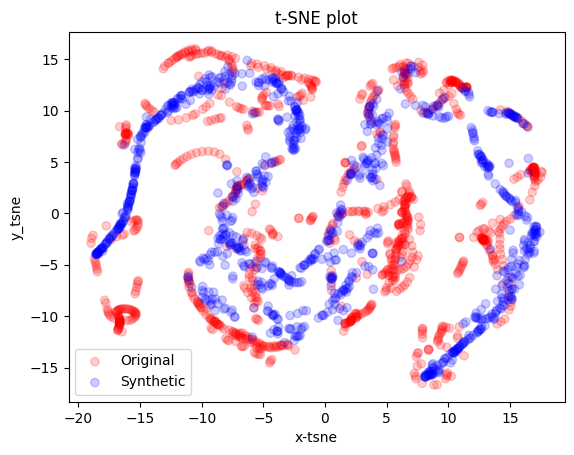

2023-01-13 14:44:39.770655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:44:39.770677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:44:51.073017: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:44:51.073039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:45:02.186089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:45:02.186112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:45:13.433535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:45:13.433564: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:45:24.798954: I tensorflow

Discriminative score: 0.4012


2023-01-13 14:45:36.240952: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:45:36.240975: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:46:05.071714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:46:05.071737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:46:32.655786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:46:32.655807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:46:58.726463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:46:58.726483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:47:27.540822: I tensorflow

Predictive score: 0.0419


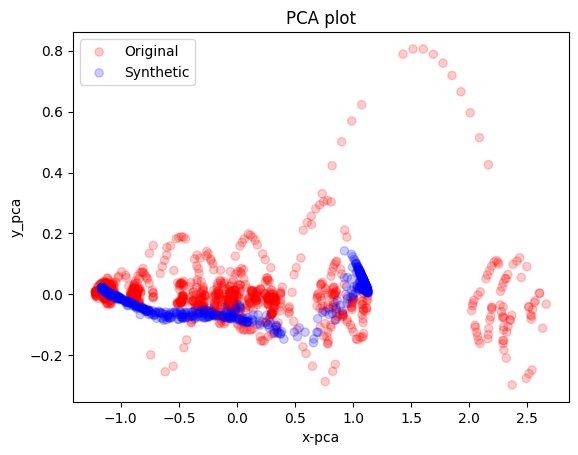

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.004419
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.497822
[t-SNE] KL divergence after 300 iterations: 0.626862


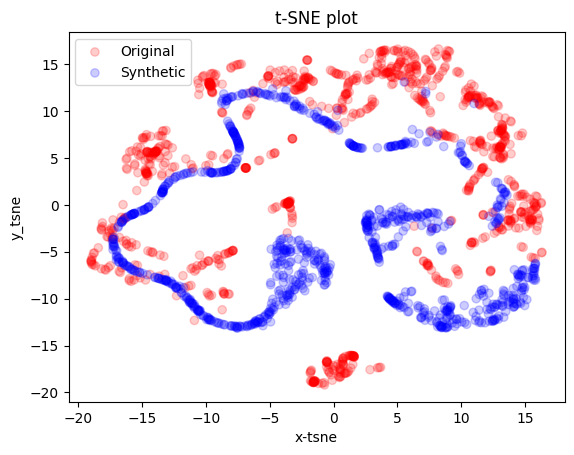

2023-01-13 14:47:56.910174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:47:56.910196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:48:08.192214: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:48:08.192236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:48:18.493897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:48:18.493917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:48:28.978746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:48:28.978769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:48:40.311887: I tensorflow

Discriminative score: 0.1377


2023-01-13 14:48:51.266198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:48:51.266224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:49:19.007846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:49:19.007867: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:49:47.250344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:49:47.250367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:50:14.983831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:50:14.983852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:50:42.810046: I tensorflow

Predictive score: 0.0379


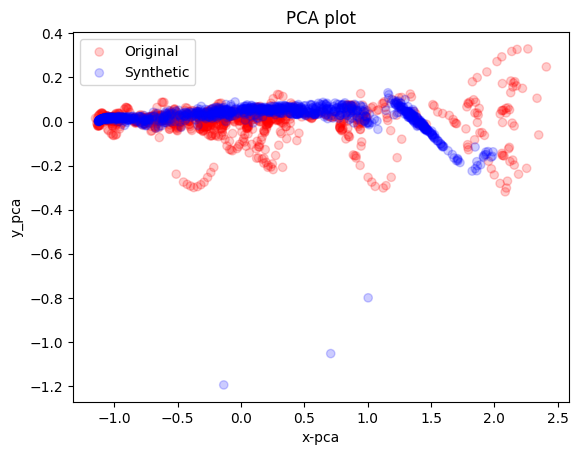

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.027831
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.662273
[t-SNE] KL divergence after 300 iterations: 0.643236


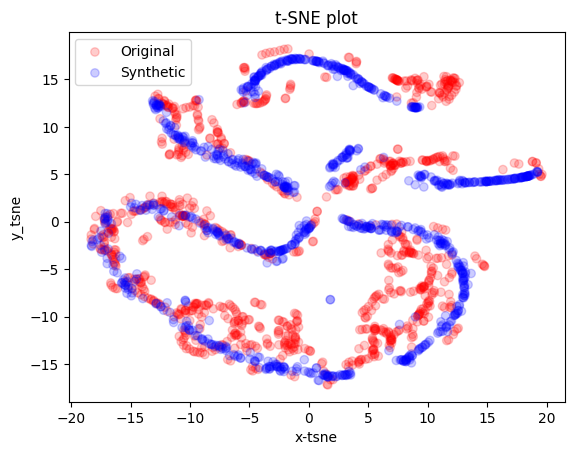

2023-01-13 14:51:10.552098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:51:10.552122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:51:21.459424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:51:21.459446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:51:32.803226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:51:32.803249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:51:44.235351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:51:44.235379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:51:55.397360: I tensorflow

Discriminative score: 0.2169


2023-01-13 14:52:06.197251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:52:06.197280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:52:33.739329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:52:33.739353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:53:01.307601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:53:01.307623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:53:28.541390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:53:28.541409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:53:55.385410: I tensorflow

Predictive score: 0.0674


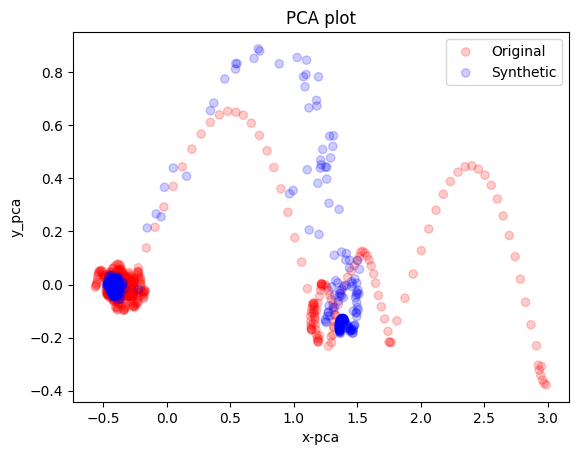

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1294 samples in 0.000s...
[t-SNE] Computed neighbors for 1294 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1294
[t-SNE] Computed conditional probabilities for sample 1294 / 1294
[t-SNE] Mean sigma: 0.035730
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.647892
[t-SNE] KL divergence after 300 iterations: 0.954859


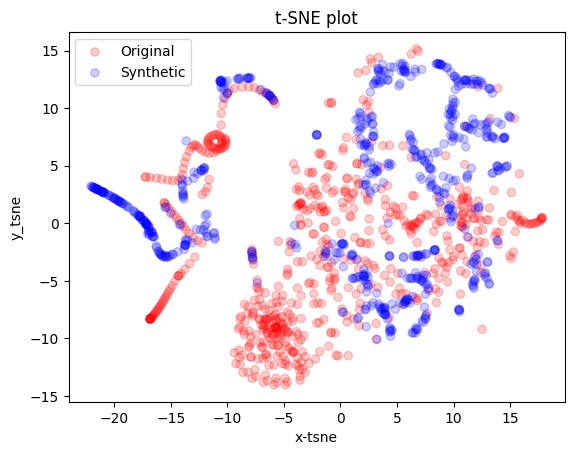

2023-01-13 14:54:24.010421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:54:24.010443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:54:35.428548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:54:35.428572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:54:46.721932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:54:46.721955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:54:58.172213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:54:58.172237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:55:09.488289: I tensorflow

Discriminative score: 0.2277


2023-01-13 14:55:20.649393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:55:20.649418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:55:48.287562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:55:48.287586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:56:16.507357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:56:16.507377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:56:42.653514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:56:42.653535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:57:11.042531: I tensorflow

Predictive score: 0.0343


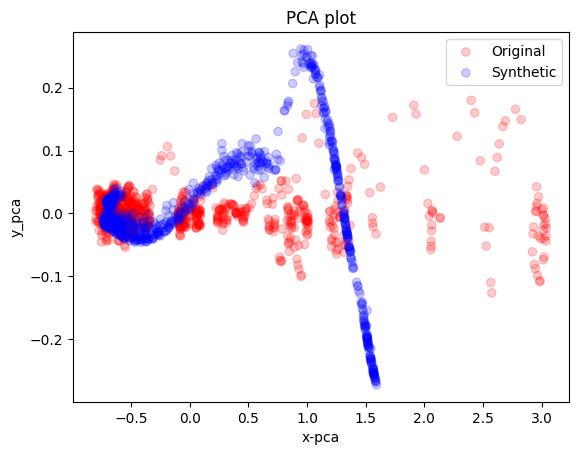

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.080s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.021201
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.697918
[t-SNE] KL divergence after 300 iterations: 0.705060


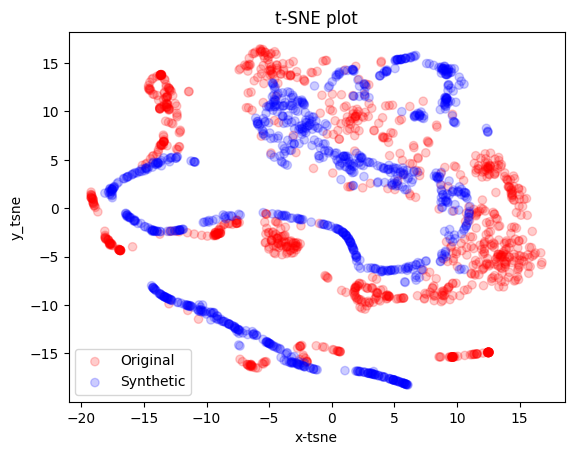

2023-01-13 14:57:40.250353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:57:40.250375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:57:51.599543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:57:51.599570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:58:02.788164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:58:02.788186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:58:14.032487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:58:14.032513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:58:25.593948: I tensorflow

Discriminative score: 0.2904


2023-01-13 14:58:36.309194: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:58:36.309219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:59:03.387847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:59:03.387874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:59:29.121006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:59:29.121028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 14:59:57.596464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 14:59:57.596488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:00:25.748477: I tensorflow

Predictive score: 0.0379


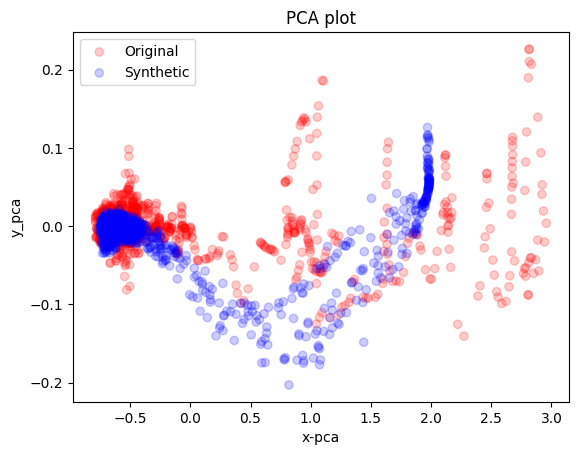

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.023316
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.828102
[t-SNE] KL divergence after 300 iterations: 0.979744


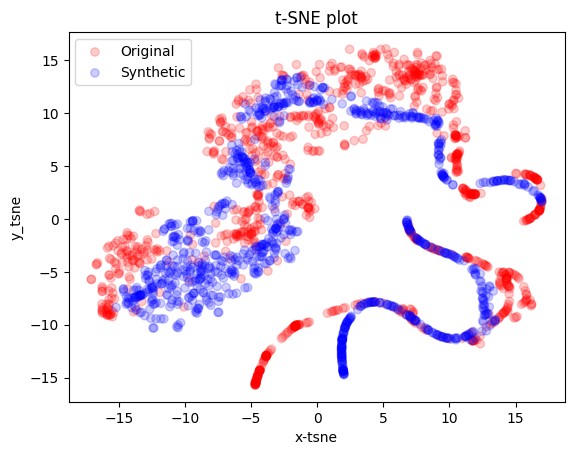

2023-01-13 15:00:55.947664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:00:55.947689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:01:07.671572: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:01:07.671595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:01:18.679638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:01:18.679661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:01:30.056513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:01:30.056531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:01:41.185209: I tensorflow

Discriminative score: 0.3206


2023-01-13 15:01:52.267138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:01:52.267160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:02:19.469323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:02:19.469346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:02:46.871442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:02:46.871463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:03:13.378137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:03:13.378157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:03:40.628737: I tensorflow

Predictive score: 0.048


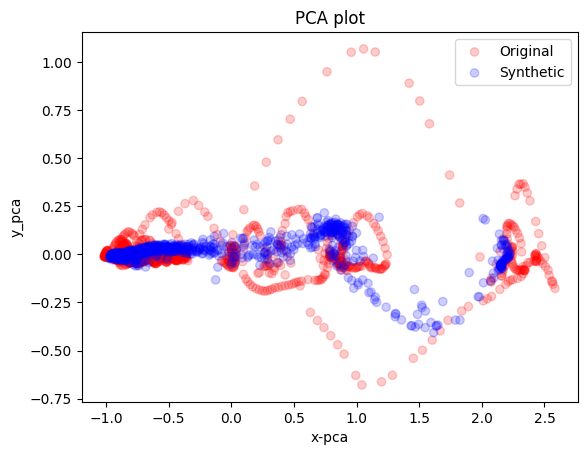

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.031763
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.999577
[t-SNE] KL divergence after 300 iterations: 0.837746


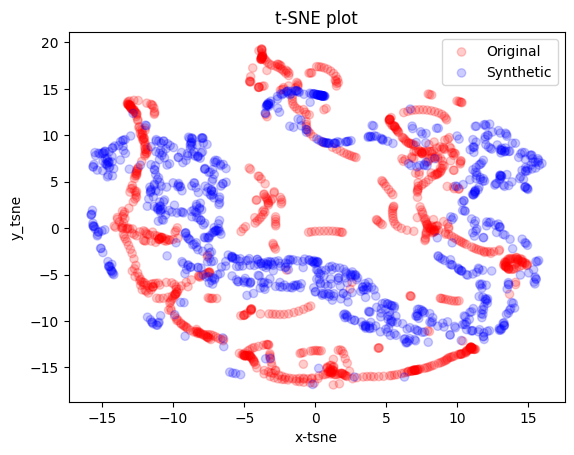

2023-01-13 15:04:09.529655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:04:09.529673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:04:20.874046: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:04:20.874067: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:04:32.224219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:04:32.224248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:04:43.568098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:04:43.568120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:04:54.944279: I tensorflow

Discriminative score: 0.2438


2023-01-13 15:05:05.602321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:05:05.602351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:05:33.147946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:05:33.147969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:06:01.378122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:06:01.378147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:06:28.212230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:06:28.212251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:06:54.102254: I tensorflow

Predictive score: 0.0226


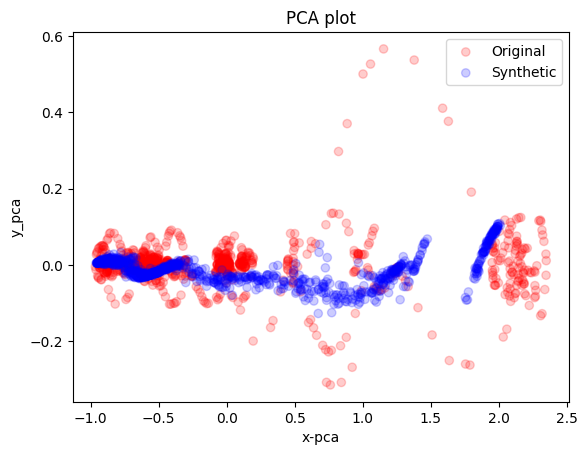

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.017410
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.067055
[t-SNE] KL divergence after 300 iterations: 0.594000


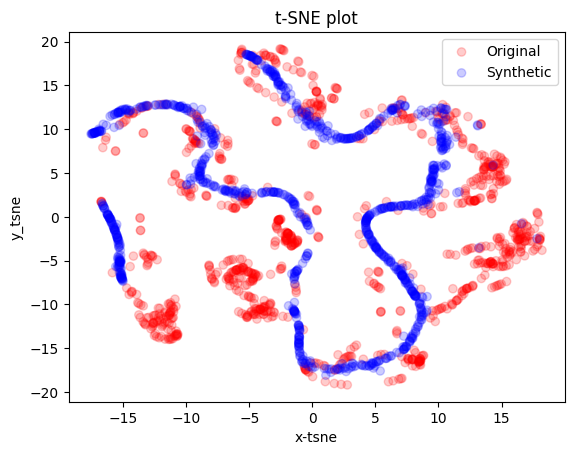

2023-01-13 15:07:23.110428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:07:23.110450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:07:34.622989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:07:34.623012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:07:46.199465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:07:46.199573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:07:57.209362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:07:57.209388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:08:08.085489: I tensorflow

Discriminative score: 0.103


2023-01-13 15:08:19.157324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:08:19.157351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:08:45.881201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:08:45.881226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:09:12.407270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:09:12.407292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:09:39.715022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:09:39.715046: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:10:07.320232: I tensorflow

Predictive score: 0.0303


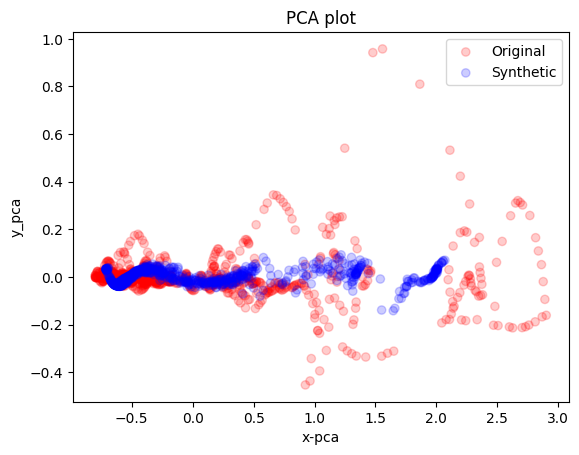

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.022166
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.361244
[t-SNE] KL divergence after 300 iterations: 0.635651


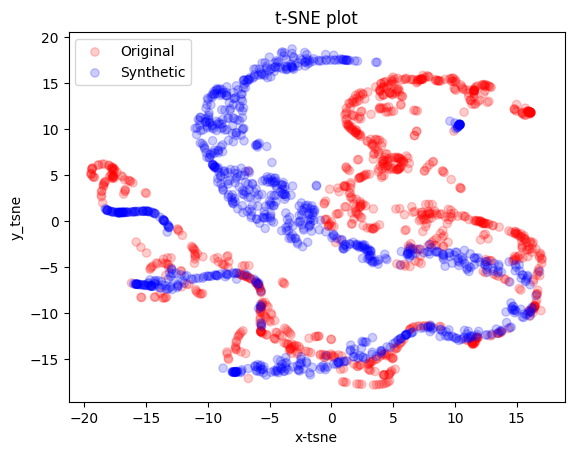

2023-01-13 15:10:35.614972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:10:35.614997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:10:46.816262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:10:46.816287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:10:58.278708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:10:58.278737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:11:09.433586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:11:09.433610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:11:20.422888: I tensorflow

Discriminative score: 0.0657


2023-01-13 15:11:31.642482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:11:31.642498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:11:59.213524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:11:59.213547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:12:25.741308: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:12:25.741411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:12:53.864909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:12:53.864929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:13:21.765584: I tensorflow

Predictive score: 0.009


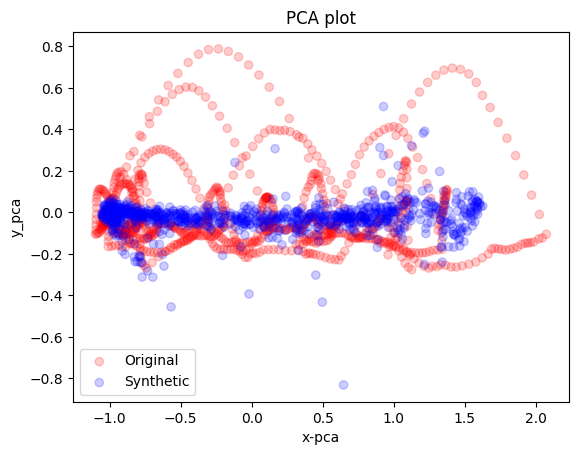

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1772 samples in 0.000s...
[t-SNE] Computed neighbors for 1772 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1772
[t-SNE] Computed conditional probabilities for sample 1772 / 1772
[t-SNE] Mean sigma: 0.064386
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.784805
[t-SNE] KL divergence after 300 iterations: 0.845137


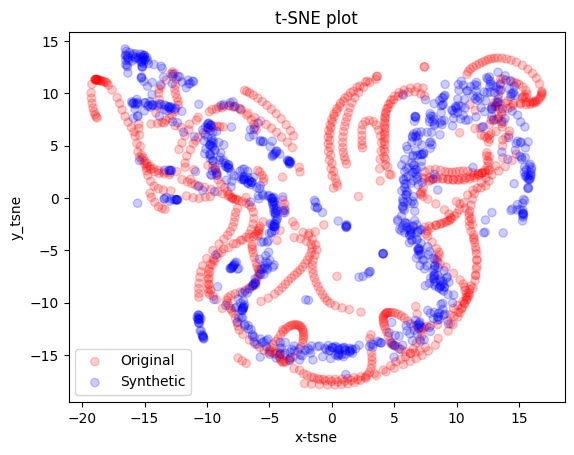

2023-01-13 15:13:50.735931: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:13:50.735958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:14:02.076706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:14:02.076731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:14:13.651649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:14:13.651671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:14:25.193777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:14:25.193799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:14:36.465565: I tensorflow

Discriminative score: 0.1209


2023-01-13 15:14:47.915613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:14:47.915636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:15:14.484039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:15:14.484062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:15:41.469655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:15:41.469677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:16:08.854677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:16:08.854703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:16:36.968416: I tensorflow

Predictive score: 0.0091


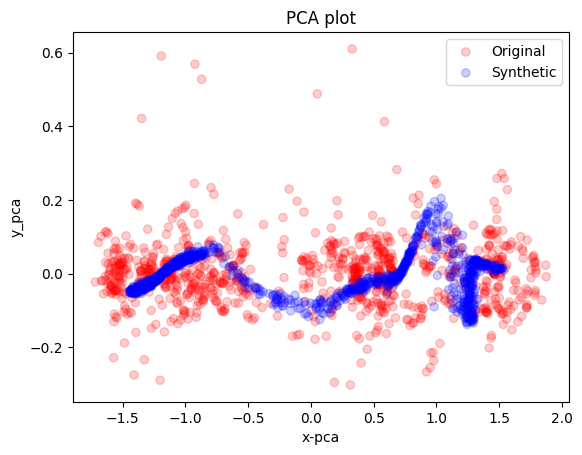

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.081s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.039901
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.529800
[t-SNE] KL divergence after 300 iterations: 0.692205


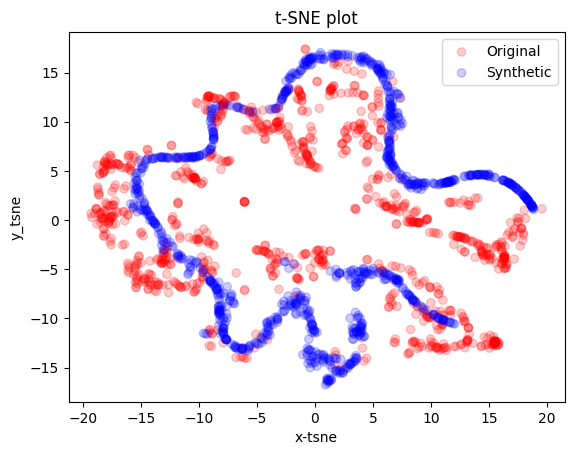

2023-01-13 15:17:07.473618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:17:07.473641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:17:18.541070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:17:18.541098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:17:29.753603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:17:29.753623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:17:41.268787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:17:41.268814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:17:52.881501: I tensorflow

Discriminative score: 0.1758


2023-01-13 15:18:03.999465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:18:03.999485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:18:31.075477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:18:31.075498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:18:59.000458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:18:59.000480: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:19:26.803742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:19:26.803764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:19:55.531906: I tensorflow

Predictive score: 0.0092


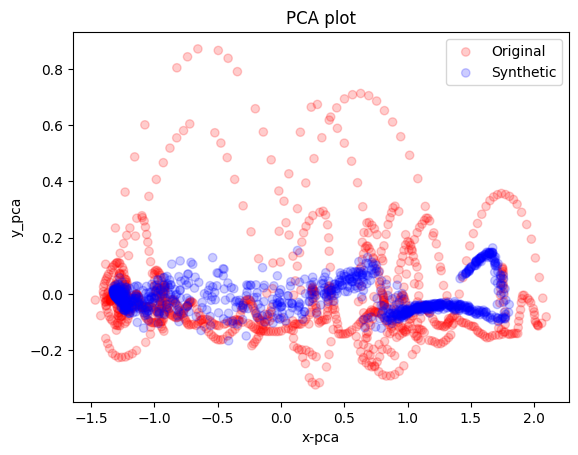

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.053499
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.702164
[t-SNE] KL divergence after 300 iterations: 0.873292


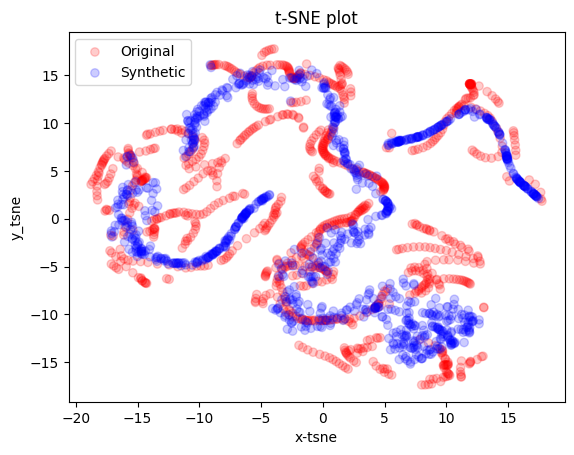

2023-01-13 15:20:24.390396: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:20:24.390415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:20:35.627643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:20:35.627668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:20:47.027652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:20:47.027675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:20:58.245143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:20:58.245170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:21:08.999998: I tensorflow

Discriminative score: 0.1893


2023-01-13 15:21:20.044346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:21:20.044366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:21:47.192685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:21:47.192707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:22:14.969549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:22:14.969571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:22:42.411673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:22:42.411695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:23:10.378665: I tensorflow

Predictive score: 0.0589


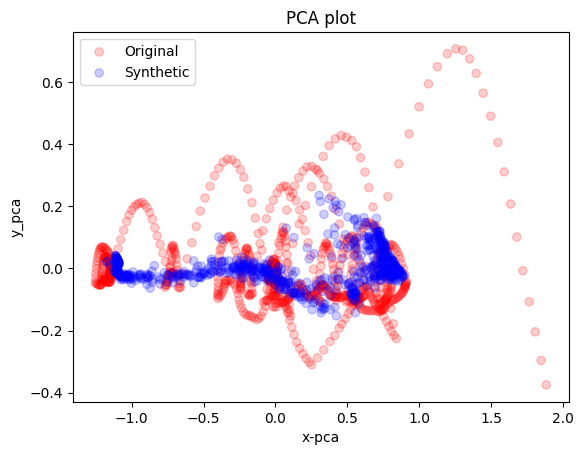

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1680 samples in 0.000s...
[t-SNE] Computed neighbors for 1680 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1680
[t-SNE] Computed conditional probabilities for sample 1680 / 1680
[t-SNE] Mean sigma: 0.024434
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.702026
[t-SNE] KL divergence after 300 iterations: 0.663090


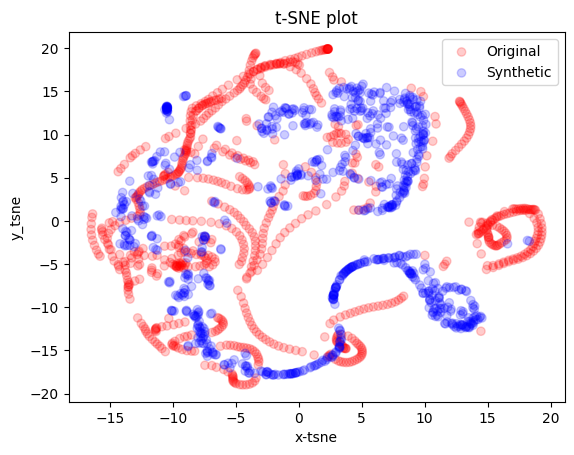

2023-01-13 15:23:38.685509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:23:38.685533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:23:50.045242: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:23:50.045266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:24:01.787640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:24:01.787668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:24:13.099225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:24:13.099252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:24:24.399468: I tensorflow

Discriminative score: 0.2126


2023-01-13 15:24:35.620283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:24:35.620305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:25:03.283059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:25:03.283082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:25:29.928226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:25:29.928247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:25:57.766280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:25:57.766303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:26:25.870453: I tensorflow

Predictive score: 0.0435


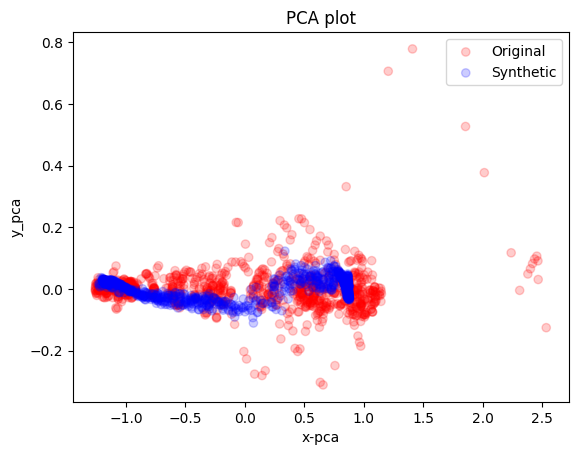

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.020617
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.672379
[t-SNE] KL divergence after 300 iterations: 0.676588


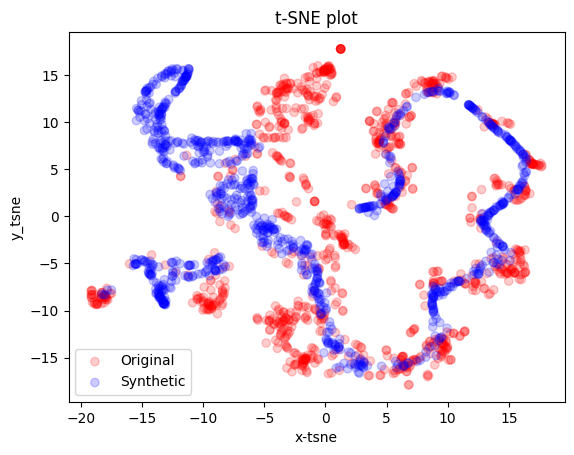

2023-01-13 15:26:55.232712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:26:55.232732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:27:06.473639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:27:06.473667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:27:17.503177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:27:17.503201: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:27:28.854026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:27:28.854049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:27:40.305149: I tensorflow

Discriminative score: 0.2113


2023-01-13 15:27:51.342825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:27:51.342847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:28:20.163228: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:28:20.163248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:28:47.752365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:28:47.752391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:29:14.995660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:29:14.995683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:29:40.615988: I tensorflow

Predictive score: 0.0638


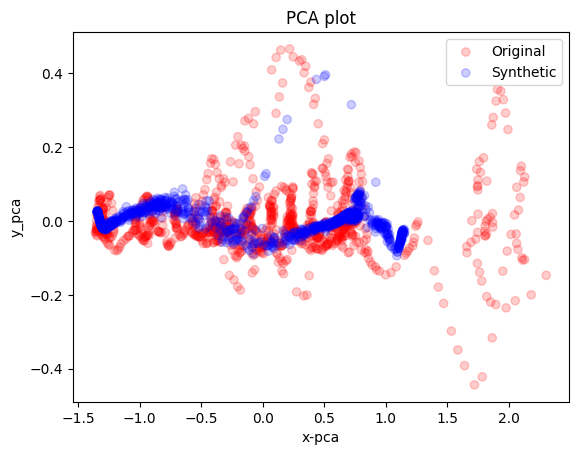

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.029436
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.807106
[t-SNE] KL divergence after 300 iterations: 0.640066


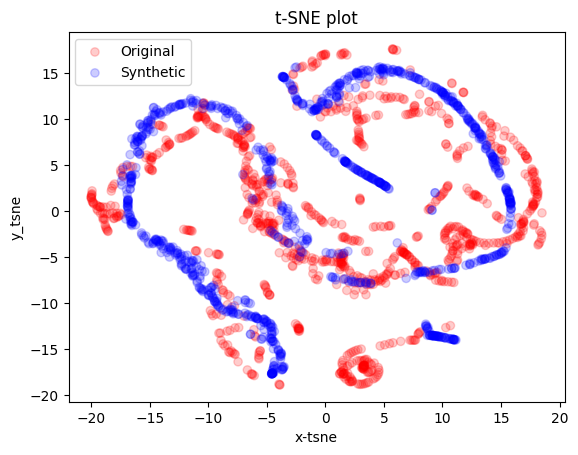

2023-01-13 15:30:09.497690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:30:09.497711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:30:21.000857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:30:21.000879: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:30:31.769935: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:30:31.769957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:30:42.742506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:30:42.742525: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:30:53.923095: I tensorflow

Discriminative score: 0.1826


2023-01-13 15:31:04.813794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:31:04.813818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:31:31.866448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:31:31.866472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:31:59.303441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:31:59.303464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:32:27.520570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:32:27.520592: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:32:54.415032: I tensorflow

Predictive score: 0.0458


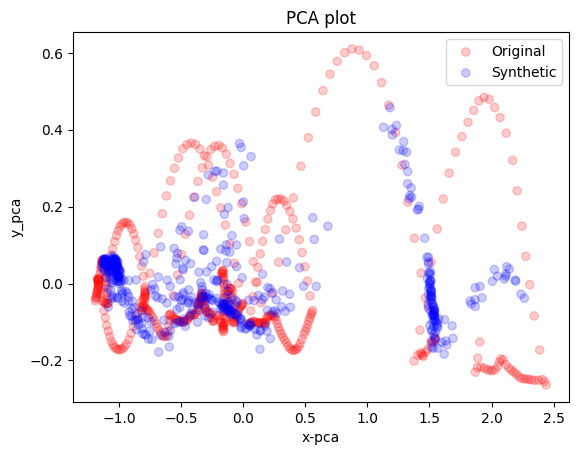

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 920 samples in 0.000s...
[t-SNE] Computed neighbors for 920 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 920 / 920
[t-SNE] Mean sigma: 0.080908
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.120052
[t-SNE] KL divergence after 300 iterations: 0.414361


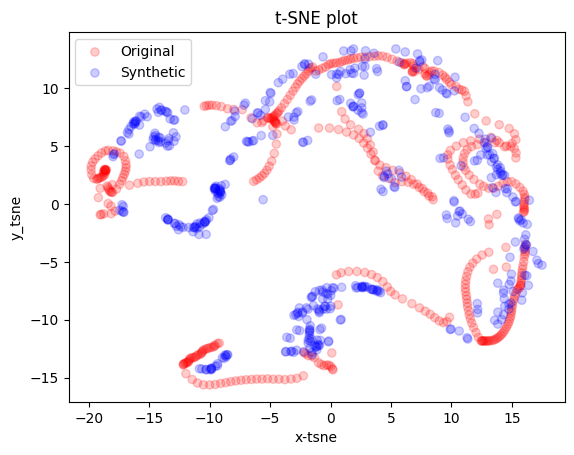

2023-01-13 15:33:23.958001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:33:23.958022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:33:35.484916: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:33:35.484938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:33:46.677943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:33:46.677973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:33:57.769963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:33:57.769986: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:34:08.996138: I tensorflow

Discriminative score: 0.2718


2023-01-13 15:34:19.627270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:34:19.627294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:34:47.587638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:34:47.587671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:35:14.624026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:35:14.624124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:35:43.108761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:35:43.108788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:36:11.411316: I tensorflow

Predictive score: 0.0224


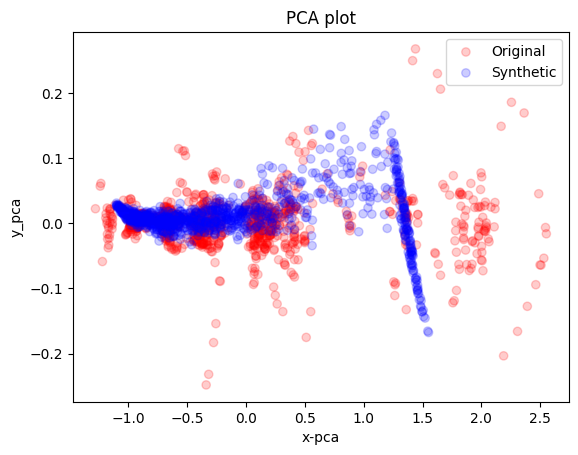

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.022945
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.948738
[t-SNE] KL divergence after 300 iterations: 0.631657


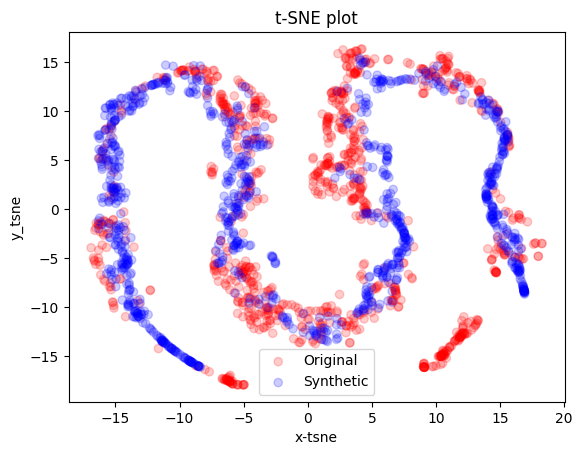

2023-01-13 15:36:41.497739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:36:41.497763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:36:52.797515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:36:52.797537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:37:04.223670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:37:04.223691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:37:15.514901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:37:15.514924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:37:26.701235: I tensorflow

Discriminative score: 0.1311


2023-01-13 15:37:37.600066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:37:37.600091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:38:04.909807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:38:04.909832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:38:32.285358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:38:32.285378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:39:00.450020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-13 15:39:00.450049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-13 15:39:27.640092: I tensorflow

Predictive score: 0.0208


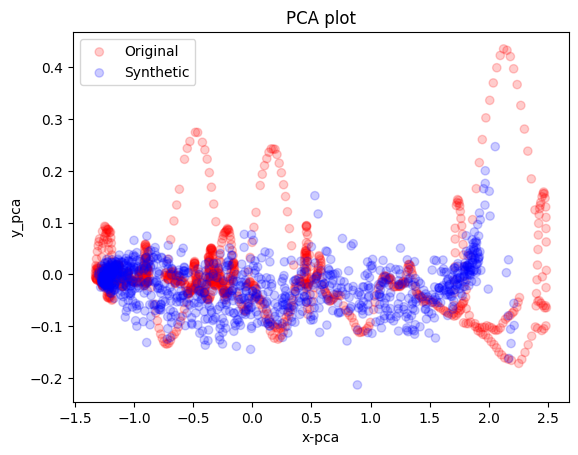

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.036138
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.944450
[t-SNE] KL divergence after 300 iterations: 0.690955


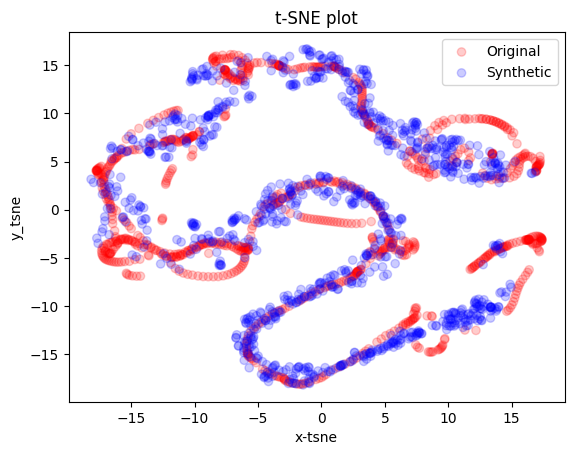

KeyError: 'HD'

In [75]:
data_dict_tic_res={}
for tic in data_dict_tic.keys():
    if tic not in data_dict_tic_res:
        data_dict_tic_res[tic]=[evaluation(data_dict_tic[tic],data_dict_tic_generated[tic])]

In [219]:
# data_dict_tic_APPL_generated=training(data_dict_tic['AAPL'])
# data_dict_group_3_generated=training(data_dict_group[3])
# GOOG_data_generated=training(GOOG_data)
# data_all_generated=training(data_all)

In [37]:
AAPL_res=[evaluation(data_dict_tic['AAPL'],data_dict_tic_APPL_generated)]
group_3_res=[evaluation(data_dict_group[3],data_dict_group_3_generated)]

Instructions for updating:
Please use tf.global_variables instead.


2023-01-12 13:37:53.701558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:37:53.701584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:38:05.460184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:38:05.460212: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:38:16.199442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:38:16.199465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:38:27.622649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:38:27.622676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:38:38.666314: I tensorflow

Discriminative score: 0.1461



2023-01-12 13:38:48.547209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:38:48.547237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:39:15.651089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:39:15.651112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:39:41.973649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:39:41.973678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:40:09.853252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:40:09.853277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:40:37.593478: I tensorflow

Predictive score: 0.0379


2023-01-12 13:41:03.991437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:41:03.991464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:41:15.045255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:41:15.045282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:41:26.302147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:41:26.302174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:41:37.859969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:41:37.859992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:41:48.085494: I tensorflow

Discriminative score: 0.1995


2023-01-12 13:41:58.385422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:41:58.385446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:42:24.344898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:42:24.344924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:42:51.451474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:42:51.451501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:43:18.004093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:43:18.004120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:43:45.123233: I tensorflow

Predictive score: 0.0342


2023-01-12 13:44:12.584365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:44:12.584398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:44:24.224137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:44:24.224159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:44:35.117427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:44:35.117457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:44:46.509254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:44:46.509282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:44:57.722528: I tensorflow

Discriminative score: 0.1561


2023-01-12 13:45:07.955286: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:45:07.955315: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:45:34.001209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:45:34.001229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:46:01.127195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:46:01.127223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:46:28.226282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:46:28.226306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:46:55.167735: I tensorflow

Predictive score: 0.026


2023-01-12 13:47:21.160588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:47:21.160607: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:47:32.750487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:47:32.750512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:47:44.088905: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:47:44.088931: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:47:55.481019: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:47:55.481047: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:48:07.194406: I tensorflow

Discriminative score: 0.3026


2023-01-12 13:48:18.861087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:48:18.861115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:48:46.403486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:48:46.403515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:49:15.439235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:49:15.439261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:49:42.437273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:49:42.437300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:50:09.627919: I tensorflow

Predictive score: 0.0567


2023-01-12 13:50:37.972873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:50:37.972899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:50:50.264598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:50:50.264624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:51:02.375476: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:51:02.375500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:51:15.125562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:51:15.125585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:51:27.941908: I tensorflow

Discriminative score: 0.3711


2023-01-12 13:51:40.293161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:51:40.293183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:52:12.361161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:52:12.361184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:52:43.451880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:52:43.451905: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:53:14.463852: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:53:14.463878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:53:46.298300: I tensorflow

Predictive score: 0.0379


2023-01-12 13:54:17.671927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:54:17.671954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:54:29.063521: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:54:29.063551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:54:40.911762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:54:40.911783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:54:52.268837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:54:52.268861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:55:03.641251: I tensorflow

Discriminative score: 0.2612


2023-01-12 13:55:15.648677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:55:15.648702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:55:44.729143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:55:44.729171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:56:14.523574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:56:14.523602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:56:43.020338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:56:43.020369: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:57:12.128360: I tensorflow

Predictive score: 0.0483


In [38]:
GOOG_data_res=[evaluation(GOOG_data,GOOG_data_generated)]
all_data_res=[evaluation(data_all,data_all_generated)]

2023-01-12 13:57:40.536604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:57:40.536628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:57:51.470666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:57:51.470693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:58:02.145376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:58:02.145402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:58:13.007036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:58:13.007062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:58:23.650814: I tensorflow

Discriminative score: 0.2081


2023-01-12 13:58:34.038635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:58:34.038660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:59:07.392910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:59:07.392939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 13:59:34.743794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 13:59:34.743830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:00:01.109189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:00:01.109210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:00:27.240985: I tensorflow

Predictive score: 0.0562


2023-01-12 14:00:53.989243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:00:53.989265: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:01:04.903957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:01:04.903985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:01:16.164287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:01:16.164314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:01:27.371889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:01:27.371915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:01:38.412699: I tensorflow

Discriminative score: 0.137


2023-01-12 14:01:49.544503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:01:49.544518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:02:15.578066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:02:15.578090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:02:43.497416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:02:43.497447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:03:14.944999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:03:14.945111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:03:45.390393: I tensorflow

Predictive score: 0.0212


2023-01-12 14:04:20.099972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:04:20.100003: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:04:31.934877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:04:31.934904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:04:43.532830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:04:43.532853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:04:53.842309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:04:53.842337: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:05:04.965239: I tensorflow

Discriminative score: 0.2725


2023-01-12 14:05:15.915299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:05:15.915322: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:05:44.338336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:05:44.338441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:06:18.228234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:06:18.228347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:06:50.876075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:06:50.876102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:07:24.000561: I tensorflow

Predictive score: 0.0462


2023-01-12 14:07:56.982247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:07:56.982275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:08:09.631108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:08:09.631137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:08:22.480667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:08:22.480690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:08:34.585464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:08:34.585487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:08:46.684635: I tensorflow

Discriminative score: 0.2521


2023-01-12 14:08:59.107192: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:08:59.107216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:09:29.801738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:09:29.801763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:10:02.220639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:10:02.220666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:10:33.637205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:10:33.637230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:11:05.218720: I tensorflow

Predictive score: 0.0614


2023-01-12 14:11:36.305526: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:11:36.305555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:11:50.455339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:11:50.455367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:12:05.215503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:12:05.215531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:12:19.956259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:12:19.956287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:12:34.135441: I tensorflow

Discriminative score: 0.1939


2023-01-12 14:12:48.982821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:12:48.982848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:13:38.484712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:13:38.484740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:14:24.013519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:14:24.013544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:15:15.327864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:15:15.327961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:16:00.813730: I tensorflow

Predictive score: 0.041


2023-01-12 14:16:57.624325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:16:57.624357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:17:11.775700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:17:11.775729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:17:28.640475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:17:28.640509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:17:44.721421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:17:44.721448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:17:58.870291: I tensorflow

Discriminative score: 0.2542


2023-01-12 14:18:11.930985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:18:11.931006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:18:45.563568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:18:45.563594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:19:18.318082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:19:18.318102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:19:52.516101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 14:19:52.516122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 14:20:26.432922: I tensorflow

Predictive score: 0.0521


In [49]:
group_4_res=[evaluation(data_dict_group[4],data_dict_group_4_generated)]

2023-01-12 16:48:57.633069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:48:57.633093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:49:09.152086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:49:09.152110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:49:20.035865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:49:20.035890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:49:31.662213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:49:31.662241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:49:42.850368: I tensorflow

Discriminative score: 0.1529


2023-01-12 16:49:54.050313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:49:54.050338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:50:20.643972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:50:20.643997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:50:47.892841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:50:47.892869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:51:17.169600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:51:17.169624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:51:44.510983: I tensorflow

Predictive score: 0.0548


2023-01-12 16:52:12.964110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:52:12.964138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:52:25.389761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:52:25.389789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:52:38.013102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:52:38.013127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:52:50.224910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:52:50.224938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:53:02.347553: I tensorflow

Discriminative score: 0.171


2023-01-12 16:53:14.901833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:53:14.901855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:53:44.112014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:53:44.112039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:54:13.112477: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:54:13.112500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:54:43.172458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:54:43.172483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:55:12.634034: I tensorflow

Predictive score: 0.0444


2023-01-12 16:55:43.682278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:55:43.682303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:55:55.371797: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:55:55.371828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:56:06.850449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:56:06.850472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:56:18.679174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:56:18.679198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:56:29.673753: I tensorflow

Discriminative score: 0.1836


2023-01-12 16:56:41.576767: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:56:41.576789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:57:09.593710: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:57:09.593734: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:57:38.338308: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:57:38.338334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:58:05.839839: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-12 16:58:05.839866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-12 16:58:32.517639: I tensorflow

Predictive score: 0.0536


## result analysis

In [43]:
display(GOOG_data_res)

[({'data_seg_GOOG_0': 673, 'data_seg_GOOG_1': 1591, 'data_seg_GOOG_2': 1529},
  {'data_seg_GOOG_0': 0.2081,
   'data_seg_GOOG_1': 0.137,
   'data_seg_GOOG_2': 0.2725},
  {'data_seg_GOOG_0': 0.0562,
   'data_seg_GOOG_1': 0.0212,
   'data_seg_GOOG_2': 0.0462})]

In [44]:
display(AAPL_res)

[({'data_seg_AAPL_0': 1147, 'data_seg_AAPL_1': 1982, 'data_seg_AAPL_2': 2583},
  {'data_seg_AAPL_0': 0.1461,
   'data_seg_AAPL_1': 0.1995,
   'data_seg_AAPL_2': 0.1561},
  {'data_seg_AAPL_0': 0.0379,
   'data_seg_AAPL_1': 0.0342,
   'data_seg_AAPL_2': 0.026})]

In [51]:
display(group_3_res)

[({'data_seg_3_0': 7738, 'data_seg_3_1': 29692, 'data_seg_3_2': 13978},
  {'data_seg_3_0': 0.3026, 'data_seg_3_1': 0.3711, 'data_seg_3_2': 0.2612},
  {'data_seg_3_0': 0.0567, 'data_seg_3_1': 0.0379, 'data_seg_3_2': 0.0483})]

In [46]:
display(all_data_res)

[({'data_seg_all_0': 25046, 'data_seg_all_1': 84788, 'data_seg_all_2': 44390},
  {'data_seg_all_0': 0.2521,
   'data_seg_all_1': 0.1939,
   'data_seg_all_2': 0.2542},
  {'data_seg_all_0': 0.0614,
   'data_seg_all_1': 0.041,
   'data_seg_all_2': 0.0521})]

In [50]:
display(group_4_res)

[({'data_seg_4_0': 5814, 'data_seg_4_1': 19734, 'data_seg_4_2': 8724},
  {'data_seg_4_0': 0.1529, 'data_seg_4_1': 0.171, 'data_seg_4_2': 0.1836},
  {'data_seg_4_0': 0.0548, 'data_seg_4_1': 0.0444, 'data_seg_4_2': 0.0536})]

In [ ]:
data_dict_tic_res={}
for tic in data_dict_tic_res.keys():
    display(data_dict_tic_res[tic])

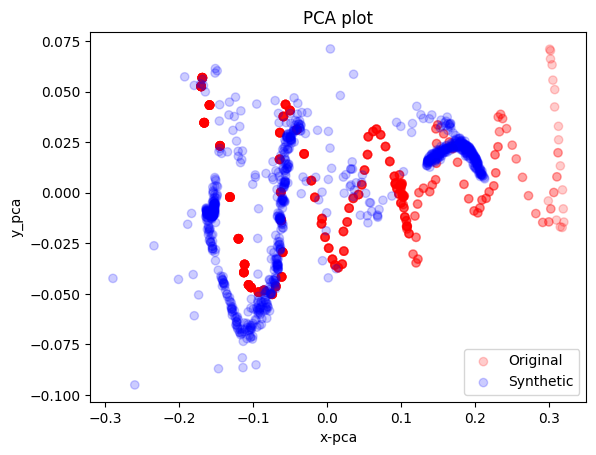

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1838 samples in 0.000s...
[t-SNE] Computed neighbors for 1838 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1838
[t-SNE] Computed conditional probabilities for sample 1838 / 1838
[t-SNE] Mean sigma: 0.015656
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.641682
[t-SNE] KL divergence after 300 iterations: 0.464388


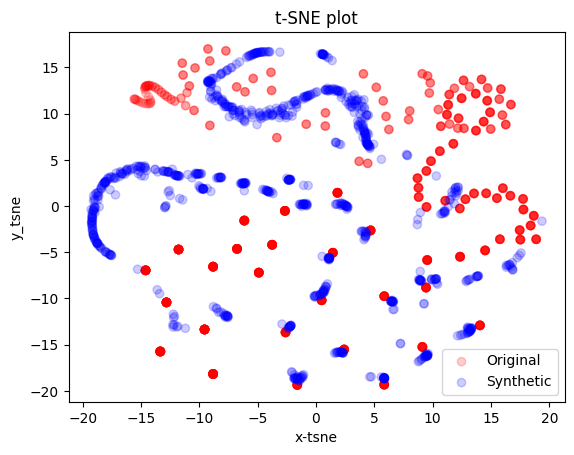

In [84]:
visualization(GOOG_processed_data,GOOG_genrated_data, 'pca')
visualization(GOOG_processed_data,GOOG_genrated_data, 'tsne')

vis of ori_stock


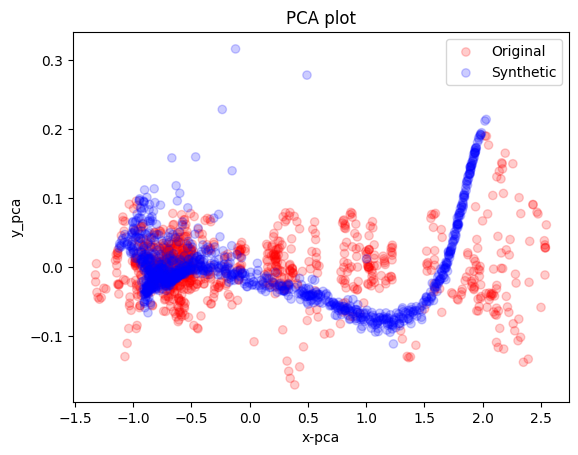

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.089s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.035023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.291069
[t-SNE] KL divergence after 300 iterations: 0.716086


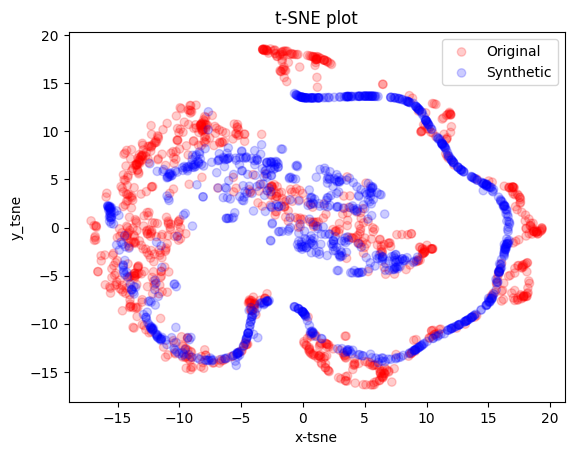

vis of group_data


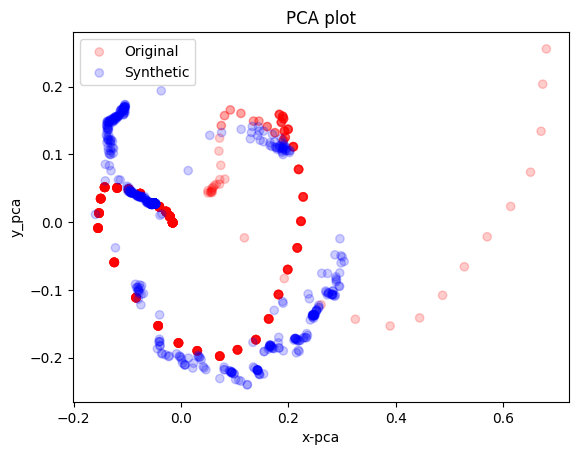

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1474 samples in 0.000s...
[t-SNE] Computed neighbors for 1474 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1474
[t-SNE] Computed conditional probabilities for sample 1474 / 1474
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.642956
[t-SNE] KL divergence after 300 iterations: 0.370412


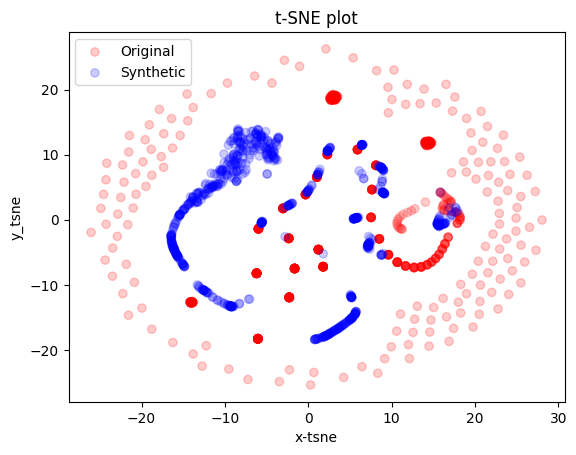

vis of single_data


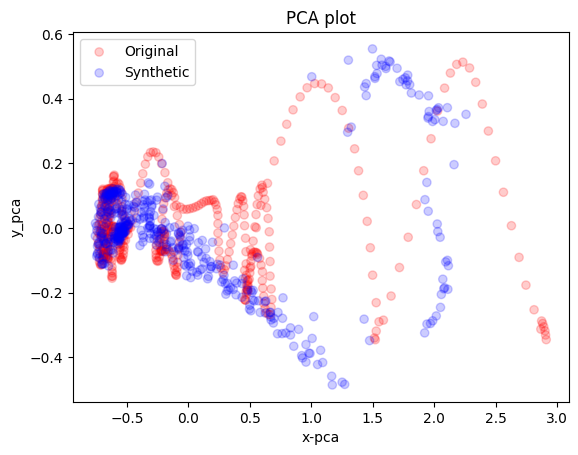

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 878 samples in 0.000s...
[t-SNE] Computed neighbors for 878 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 878 / 878
[t-SNE] Mean sigma: 0.071760
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.651947
[t-SNE] KL divergence after 300 iterations: 0.514388


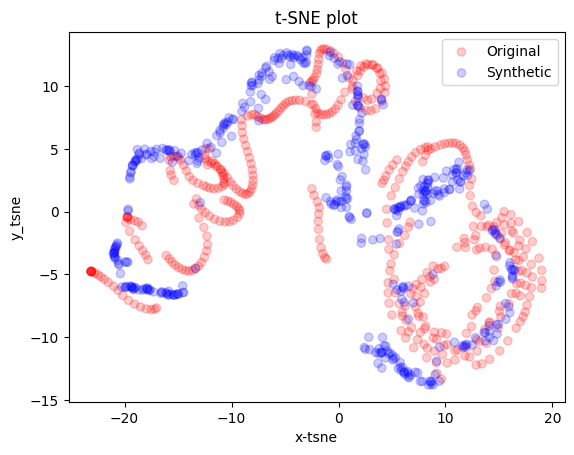

In [32]:
for k in data_dict.keys():
    print('vis of '+k)
    visualization(data_dict[k], generated_data_dict[k], 'pca')
    visualization(data_dict[k], generated_data_dict[k], 'tsne')

# Leverage Effect

In [21]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].pct_return.to_numpy()
        std=data_seg.std()
        std_list.append(std)
    return std_list

single stock

In [22]:
for tic in tics:
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+tic+'_'+str(j)+'.csv')
        print('stock',tic,'regime',j)
        std_list=get_std_list(data)
        display(pd.DataFrame(std_list).describe()) 

stock AAPL regime 0


0
count  9.000000
mean   0.020886
std    0.005832
min    0.014411
25%    0.016206
50%    0.019266
75%    0.024828
max    0.029776

stock AAPL regime 1


0
count  17.000000
mean    0.017245
std     0.010832
min     0.007756
25%     0.010101
50%     0.016661
75%     0.017717
max     0.053692

stock AAPL regime 2


0
count  20.000000
mean    0.014343
std     0.002985
min     0.009344
25%     0.011940
50%     0.014121
75%     0.016689
max     0.020478

stock AMGN regime 0


0
count  10.000000
mean    0.018457
std     0.007132
min     0.008482
25%     0.014735
50%     0.018346
75%     0.020121
max     0.035298

stock AMGN regime 1


0
count  17.000000
mean    0.013193
std     0.003837
min     0.007035
25%     0.010569
50%     0.012758
75%     0.016803
max     0.019731

stock AMGN regime 2


0
count  18.000000
mean    0.014601
std     0.005595
min     0.008663
25%     0.011883
50%     0.012885
75%     0.014921
max     0.033364

stock AXP regime 0


0
count  7.000000
mean   0.024677
std    0.017537
min    0.013524
25%    0.014503
50%    0.017983
75%    0.024623
max    0.062980

stock AXP regime 1


0
count  14.000000
mean    0.013264
std     0.003123
min     0.008602
25%     0.011367
50%     0.013067
75%     0.014057
max     0.021121

stock AXP regime 2


0
count  13.000000
mean    0.017798
std     0.014756
min     0.006297
25%     0.010527
50%     0.011283
75%     0.015654
max     0.054664

stock BA regime 0


0
count  12.000000
mean    0.027113
std     0.019939
min     0.017164
25%     0.017862
50%     0.018759
75%     0.026153
max     0.086811

stock BA regime 1


0
count  17.000000
mean    0.014748
std     0.005271
min     0.008151
25%     0.010665
50%     0.013286
75%     0.016750
max     0.028495

stock BA regime 2


0
count  15.000000
mean    0.020900
std     0.014356
min     0.010215
25%     0.012652
50%     0.015414
75%     0.019937
max     0.063674

stock CAT regime 0


0
count  12.000000
mean    0.019207
std     0.006595
min     0.010924
25%     0.016305
50%     0.017977
75%     0.019243
max     0.038002

stock CAT regime 1


0
count  17.000000
mean    0.015225
std     0.005155
min     0.009853
25%     0.012382
50%     0.013752
75%     0.016417
max     0.031207

stock CAT regime 2


0
count  17.000000
mean    0.015252
std     0.004367
min     0.008396
25%     0.011758
50%     0.015776
75%     0.017079
max     0.024293

stock CRM regime 0


0
count  12.000000
mean    0.023008
std     0.008020
min     0.012316
25%     0.017586
50%     0.020573
75%     0.026596
max     0.041117

stock CRM regime 1


0
count  16.000000
mean    0.017630
std     0.006907
min     0.008040
25%     0.014099
50%     0.015094
75%     0.021482
max     0.036083

stock CRM regime 2


0
count  20.000000
mean    0.017953
std     0.006665
min     0.008195
25%     0.012943
50%     0.018631
75%     0.020530
max     0.036507

stock CSCO regime 0


0
count  9.000000
mean   0.020394
std    0.008696
min    0.012350
25%    0.015687
50%    0.018472
75%    0.020613
max    0.041375

stock CSCO regime 1


0
count  20.000000
mean    0.012910
std     0.003702
min     0.006808
25%     0.009928
50%     0.013023
75%     0.016519
max     0.017905

stock CSCO regime 2


0
count  19.000000
mean    0.014008
std     0.005992
min     0.007371
25%     0.009631
50%     0.012730
75%     0.015477
max     0.032123

stock CVX regime 0


0
count  9.000000
mean   0.018519
std    0.011985
min    0.008873
25%    0.011606
50%    0.014777
75%    0.018470
max    0.048028

stock CVX regime 1


0
count  19.000000
mean    0.012495
std     0.004883
min     0.007547
25%     0.008929
50%     0.011013
75%     0.015136
max     0.026123

stock CVX regime 2


0
count  14.000000
mean    0.016988
std     0.014404
min     0.006644
25%     0.009190
50%     0.011976
75%     0.018730
max     0.061690

stock DIS regime 0


0
count  6.000000
mean   0.019686
std    0.010352
min    0.010053
25%    0.013921
50%    0.015656
75%    0.022716
max    0.038341

stock DIS regime 1


0
count  15.000000
mean    0.011357
std     0.003864
min     0.007272
25%     0.008967
50%     0.010982
75%     0.012398
max     0.023682

stock DIS regime 2


0
count  17.000000
mean    0.014886
std     0.007895
min     0.007817
25%     0.009583
50%     0.011024
75%     0.018238
max     0.038246

stock GS regime 0


0
count  8.000000
mean   0.015862
std    0.003243
min    0.011987
25%    0.012963
50%    0.016125
75%    0.017656
max    0.020861

stock GS regime 1


0
count  18.000000
mean    0.014124
std     0.003141
min     0.009119
25%     0.012483
50%     0.013274
75%     0.016205
max     0.022705

stock GS regime 2


0
count  14.000000
mean    0.016079
std     0.007873
min     0.007386
25%     0.011814
50%     0.013994
75%     0.018577
max     0.039248

stock HD regime 0


0
count  6.000000
mean   0.013588
std    0.002935
min    0.010412
25%    0.011132
50%    0.013522
75%    0.015224
max    0.017947

stock HD regime 1


0
count  14.000000
mean    0.011409
std     0.003258
min     0.005691
25%     0.009383
50%     0.011984
75%     0.012549
max     0.018313

stock HD regime 2


0
count  17.000000
mean    0.011311
std     0.004157
min     0.005933
25%     0.008849
50%     0.010106
75%     0.012335
max     0.025105

stock HON regime 0


0
count  6.000000
mean   0.018851
std    0.009982
min    0.011725
25%    0.014647
50%    0.015071
75%    0.017188
max    0.038841

stock HON regime 1


0
count  15.000000
mean    0.011722
std     0.003849
min     0.006694
25%     0.009353
50%     0.010751
75%     0.013562
max     0.022448

stock HON regime 2


0
count  14.000000
mean    0.014191
std     0.007963
min     0.007350
25%     0.009491
50%     0.012002
75%     0.015277
max     0.038706

stock IBM regime 0


0
count  10.000000
mean    0.018048
std     0.010009
min     0.008656
25%     0.013978
50%     0.016568
75%     0.017594
max     0.044808

stock IBM regime 1


0
count  19.000000
mean    0.011759
std     0.003229
min     0.008072
25%     0.009021
50%     0.010737
75%     0.013965
max     0.018619

stock IBM regime 2


0
count  14.000000
mean    0.012814
std     0.006264
min     0.006335
25%     0.008650
50%     0.011873
75%     0.014200
max     0.031138

stock INTC regime 0


0
count  9.000000
mean   0.019607
std    0.005959
min    0.011808
25%    0.016794
50%    0.017270
75%    0.023452
max    0.030637

stock INTC regime 1


0
count  19.000000
mean    0.017721
std     0.011860
min     0.008906
25%     0.011959
50%     0.013236
75%     0.019605
max     0.061900

stock INTC regime 2


0
count  20.000000
mean    0.016157
std     0.004900
min     0.008471
25%     0.013351
50%     0.014784
75%     0.018353
max     0.027779

stock JNJ regime 0


0
count  3.000000
mean   0.025103
std    0.014495
min    0.011309
25%    0.017550
50%    0.023791
75%    0.032001
max    0.040210

stock JNJ regime 1


0
count  13.000000
mean    0.009092
std     0.002080
min     0.006035
25%     0.007894
50%     0.008919
75%     0.010071
max     0.013525

stock JNJ regime 2


0
count  9.000000
mean   0.009336
std    0.006063
min    0.005361
25%    0.005893
50%    0.007991
75%    0.008974
max    0.024854

stock JPM regime 0


0
count  7.000000
mean   0.015824
std    0.005064
min    0.008073
25%    0.012170
50%    0.017246
75%    0.019783
max    0.021541

stock JPM regime 1


0
count  23.000000
mean    0.013212
std     0.003814
min     0.007758
25%     0.011203
50%     0.012298
75%     0.013779
max     0.026322

stock JPM regime 2


0
count  21.000000
mean    0.013212
std     0.007471
min     0.006247
25%     0.009320
50%     0.012661
75%     0.013716
max     0.041648

stock KO regime 0


0
count  2.000000
mean   0.023115
std    0.024944
min    0.005477
25%    0.014296
50%    0.023115
75%    0.031934
max    0.040753

stock KO regime 1


0
count  8.000000
mean   0.011583
std    0.005955
min    0.006055
25%    0.008776
50%    0.009750
75%    0.011760
max    0.025162

stock KO regime 2


0
count  7.000000
mean   0.009796
std    0.003357
min    0.006646
25%    0.007227
50%    0.007996
75%    0.012066
max    0.015346

stock MCD regime 0


0
count  6.000000
mean   0.011296
std    0.003805
min    0.005854
25%    0.009939
50%    0.010927
75%    0.012549
max    0.017369

stock MCD regime 1


0
count  14.000000
mean    0.009387
std     0.002223
min     0.005603
25%     0.008299
50%     0.008799
75%     0.010520
max     0.014648

stock MCD regime 2


0
count  10.000000
mean    0.012681
std     0.008789
min     0.007032
25%     0.007582
50%     0.007956
75%     0.015536
max     0.035294

stock MMM regime 0


0
count  6.000000
mean   0.017538
std    0.004286
min    0.011715
25%    0.015600
50%    0.016772
75%    0.019685
max    0.024104

stock MMM regime 1


0
count  19.000000
mean    0.012554
std     0.009420
min     0.004704
25%     0.008195
50%     0.010561
75%     0.012778
max     0.049003

stock MMM regime 2


0
count  17.000000
mean    0.011215
std     0.004425
min     0.005575
25%     0.009531
50%     0.010696
75%     0.013040
max     0.023537

stock MRK regime 0


0
count  3.000000
mean   0.016784
std    0.004087
min    0.014200
25%    0.014428
50%    0.014655
75%    0.018076
max    0.021496

stock MRK regime 1


0
count  14.000000
mean    0.011313
std     0.003039
min     0.006341
25%     0.009878
50%     0.010909
75%     0.013411
max     0.016603

stock MRK regime 2


0
count  11.000000
mean    0.011679
std     0.003433
min     0.008438
25%     0.009684
50%     0.011112
75%     0.012252
max     0.020894

stock MSFT regime 0


0
count  6.000000
mean   0.025549
std    0.017804
min    0.010869
25%    0.015959
50%    0.021984
75%    0.023599
max    0.060369

stock MSFT regime 1


0
count  19.000000
mean    0.013887
std     0.003825
min     0.008238
25%     0.011369
50%     0.013130
75%     0.015203
max     0.021975

stock MSFT regime 2


0
count  15.000000
mean    0.013852
std     0.004734
min     0.007278
25%     0.011330
50%     0.012294
75%     0.014921
max     0.024934

stock NKE regime 0


0
count  9.000000
mean   0.014581
std    0.002907
min    0.011431
25%    0.012084
50%    0.014465
75%    0.015371
max    0.020282

stock NKE regime 1


0
count  20.000000
mean    0.014166
std     0.004296
min     0.008302
25%     0.011321
50%     0.012934
75%     0.017029
max     0.026094

stock NKE regime 2


0
count  18.000000
mean    0.016116
std     0.007128
min     0.007548
25%     0.012258
50%     0.013901
75%     0.017830
max     0.035638

stock PG regime 0


0
count  3.000000
mean   0.012125
std    0.001439
min    0.010929
25%    0.011327
50%    0.011725
75%    0.012723
max    0.013722

stock PG regime 1


0
count  13.000000
mean    0.010339
std     0.004781
min     0.005115
25%     0.008374
50%     0.009052
75%     0.009915
max     0.024338

stock PG regime 2


0
count  10.000000
mean    0.010131
std     0.003470
min     0.005038
25%     0.009115
50%     0.009633
75%     0.010328
max     0.018585

stock TRV regime 0


0
count  3.000000
mean   0.014911
std    0.002350
min    0.013524
25%    0.013555
50%    0.013586
75%    0.015605
max    0.017625

stock TRV regime 1


0
count  15.000000
mean    0.012086
std     0.006394
min     0.006138
25%     0.009611
50%     0.010185
75%     0.012594
max     0.033192

stock TRV regime 2


0
count  12.000000
mean    0.012519
std     0.006222
min     0.005832
25%     0.009488
50%     0.010987
75%     0.012483
max     0.026897

stock UNH regime 0


0
count  6.000000
mean   0.024183
std    0.019191
min    0.012270
25%    0.014071
50%    0.018859
75%    0.019607
max    0.062775

stock UNH regime 1


0
count  17.000000
mean    0.012867
std     0.003328
min     0.007100
25%     0.010705
50%     0.012346
75%     0.014815
max     0.020521

stock UNH regime 2


0
count  17.000000
mean    0.014800
std     0.008761
min     0.007611
25%     0.011917
50%     0.012493
75%     0.014221
max     0.045789

stock V regime 0


0
count  4.000000
mean   0.022324
std    0.013280
min    0.013264
25%    0.014120
50%    0.017131
75%    0.025335
max    0.041771

stock V regime 1


0
count  14.000000
mean    0.013458
std     0.003722
min     0.009598
25%     0.010751
50%     0.012039
75%     0.015251
max     0.023545

stock V regime 2


0
count  14.000000
mean    0.014268
std     0.007136
min     0.008029
25%     0.010477
50%     0.013195
75%     0.014505
max     0.036526

stock VZ regime 0


0
count  4.000000
mean   0.010043
std    0.001265
min    0.008178
25%    0.009893
50%    0.010501
75%    0.010651
max    0.010993

stock VZ regime 1


0
count  13.000000
mean    0.009880
std     0.002028
min     0.007410
25%     0.008679
50%     0.009388
75%     0.010611
max     0.013589

stock VZ regime 2


0
count  12.000000
mean    0.010440
std     0.002789
min     0.007630
25%     0.008132
50%     0.009550
75%     0.012455
max     0.015572

stock WBA regime 0


0
count  9.000000
mean   0.022262
std    0.006597
min    0.014130
25%    0.018390
50%    0.020482
75%    0.022977
max    0.035872

stock WBA regime 1


0
count  18.000000
mean    0.014984
std     0.006472
min     0.007156
25%     0.011358
50%     0.013401
75%     0.017917
max     0.036767

stock WBA regime 2


0
count  14.000000
mean    0.016176
std     0.005131
min     0.010139
25%     0.013413
50%     0.014585
75%     0.018646
max     0.029334

stock WMT regime 0


0
count  4.000000
mean   0.016112
std    0.006253
min    0.009454
25%    0.012207
50%    0.015550
75%    0.019456
max    0.023895

stock WMT regime 1


0
count  14.000000
mean    0.010104
std     0.001750
min     0.006695
25%     0.009303
50%     0.010270
75%     0.011120
max     0.013059

stock WMT regime 2


0
count  11.000000
mean    0.014393
std     0.009599
min     0.007177
25%     0.009215
50%     0.012513
75%     0.014283
max     0.041882

by stock group

In [23]:
for i in range(stock_group_num):
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv')
        print('stock',i,'regime',j)
        std_list=get_std_list(data)
        display(pd.DataFrame(std_list).describe()) 

stock 0 regime 0


0
count  69.000000
mean    0.020105
std     0.011980
min     0.006847
25%     0.013403
50%     0.016698
75%     0.023791
max     0.067049

stock 0 regime 1


0
count  171.000000
mean     0.012485
std      0.005480
min      0.005115
25%      0.009293
50%      0.011299
75%      0.013559
max      0.053692

stock 0 regime 2


0
count  154.000000
mean     0.014259
std      0.008526
min      0.005038
25%      0.009588
50%      0.012082
75%      0.015621
max      0.061690

stock 1 regime 0


0
count  29.000000
mean    0.021239
std     0.015733
min     0.000575
25%     0.012693
50%     0.017133
75%     0.020818
max     0.062775

stock 1 regime 1


0
count  71.000000
mean    0.013268
std     0.003449
min     0.005691
25%     0.011043
50%     0.012773
75%     0.015203
max     0.022705

stock 1 regime 2


0
count  66.000000
mean    0.013889
std     0.006593
min     0.005933
25%     0.010920
50%     0.012315
75%     0.014381
max     0.045789

stock 2 regime 0


0
count  41.000000
mean    0.018817
std     0.008533
min     0.000693
25%     0.013287
50%     0.018390
75%     0.022643
max     0.041375

stock 2 regime 1


0
count  97.000000
mean    0.013470
std     0.006964
min     0.006055
25%     0.009790
50%     0.012163
75%     0.015842
max     0.061900

stock 2 regime 2


0
count  88.000000
mean    0.013562
std     0.005088
min     0.006646
25%     0.010072
50%     0.012872
75%     0.015347
max     0.032123

stock 3 regime 0


0
count  62.000000
mean    0.019403
std     0.008821
min     0.005854
25%     0.014461
50%     0.017516
75%     0.020580
max     0.051852

stock 3 regime 1


0
count  118.000000
mean     0.013290
std      0.005910
min      0.004704
25%      0.009846
50%      0.011998
75%      0.015015
max      0.049003

stock 3 regime 2


0
count  115.000000
mean     0.014257
std      0.006511
min      0.005569
25%      0.009927
50%      0.012684
75%      0.016127
max      0.038706

stock 4 regime 0


0
count  10.000000
mean    0.018048
std     0.010009
min     0.008656
25%     0.013978
50%     0.016568
75%     0.017594
max     0.044808

stock 4 regime 1


0
count  19.000000
mean    0.011759
std     0.003229
min     0.008072
25%     0.009021
50%     0.010737
75%     0.013965
max     0.018619

stock 4 regime 2


0
count  14.000000
mean    0.012814
std     0.006264
min     0.006335
25%     0.008650
50%     0.011873
75%     0.014200
max     0.031138

stock 5 regime 0


0
count  12.000000
mean    0.027113
std     0.019939
min     0.017164
25%     0.017862
50%     0.018759
75%     0.026153
max     0.086811

stock 5 regime 1


0
count  17.000000
mean    0.014748
std     0.005271
min     0.008151
25%     0.010665
50%     0.013286
75%     0.016750
max     0.028495

stock 5 regime 2


0
count  15.000000
mean    0.020900
std     0.014356
min     0.010215
25%     0.012652
50%     0.015414
75%     0.019937
max     0.063674

In [24]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        std=data_seg.adj.std()
        std_list.append(std)
    return std_list

# key takeaway
1. regime 0 has high variance mean and high variance variance
2. regime 1 has low variance mean and low variance variance
3. regime 2 has low variance mean and low/high variance variance

# Pre-train Static learning classification discriminator

In [67]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sktime.classification.kernel_based import RocketClassifier

In [ ]:
def get_data_of_same_length_df(data,seq_len):
    data_processed=[]
    intervals=get_intervals(data)
    temp_data=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:]
        for i in range(0, len(data_seg) - seq_len):
            _x = data[i:i + seq_len]
            temp_data.append(_x)
    return temp_data

In [59]:
data=pd.read_csv('data_seg_'+"0"+'_'+"0"+'.csv')
display(data.columns)

Index(['Unnamed: 0', 'index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered'],
      dtype='object')

In [ ]:
for tic in tics:
    print(tic)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+tic+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length_df(data,24)
        label=np.full(len(process_data), j)
        X.extend(process_data)
        y=np.concatenate((y, label), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier = RocketClassifier(num_kernels=2000,n_jobs=-1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))

ALL single stock classification have unbelieve 100% acc?

In [92]:
for i in range(stock_group_num):
    print('stock_group',i)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length_df(data,24)
        label=np.full(len(process_data), j)
        X.extend(process_data)
        y=np.concatenate((y, label), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier = RocketClassifier(num_kernels=2000,n_jobs=-1,use_multivariate='yes')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))

stock_group 0
1.0
stock_group 1
1.0
stock_group 2
1.0
stock_group 3
1.0
stock_group 4
1.0
stock_group 5
1.0


Still 1.0?

In [48]:

# X_train, X_test, y_train, y_test = train_test_split(X, y)
# classifier = TimeSeriesForestClassifier()
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# accuracy_score(y_test, y_pred)

# Pre-train Deep learning classification discriminator

### training

In [49]:
from tsai.all import *
my_setup()

os              : Linux-5.8.0-49-generic-x86_64-with-debian-bullseye-sid
python          : 3.7.15
tsai            : 0.3.5
fastai          : 2.7.10
fastcore        : 1.5.27
torch           : 1.13.1+cu117
device          : 4 gpus (['GeForce RTX 3090', 'GeForce RTX 3090', 'GeForce RTX 3090', 'GeForce RTX 3090'])
cpu cores       : 40
threads per cpu : 2
RAM             : 376.58 GB
GPU memory      : [23.7, 23.7, 23.7, 23.7] GB


stock_group 0


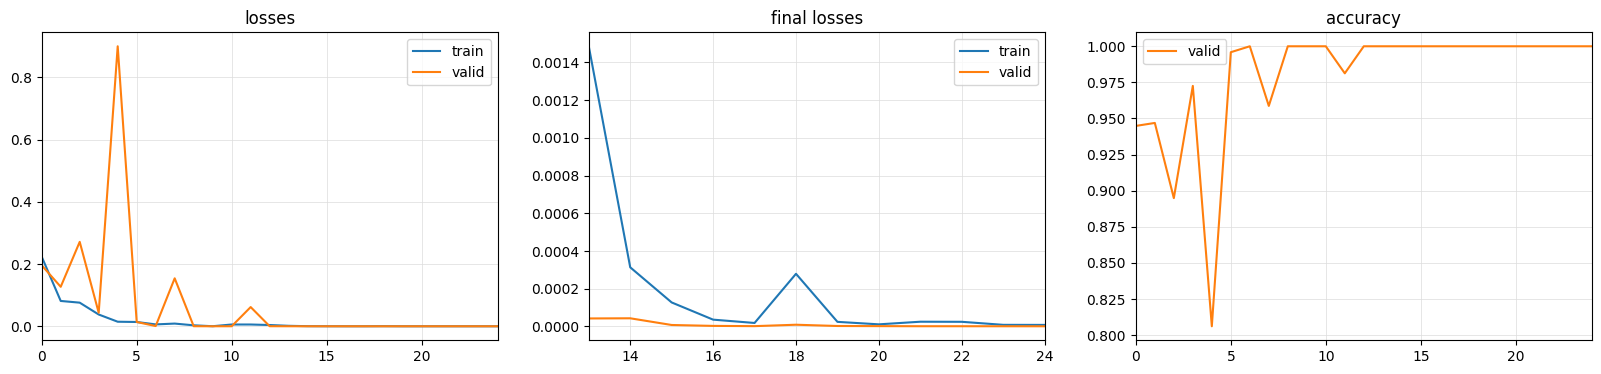

stock_group 1


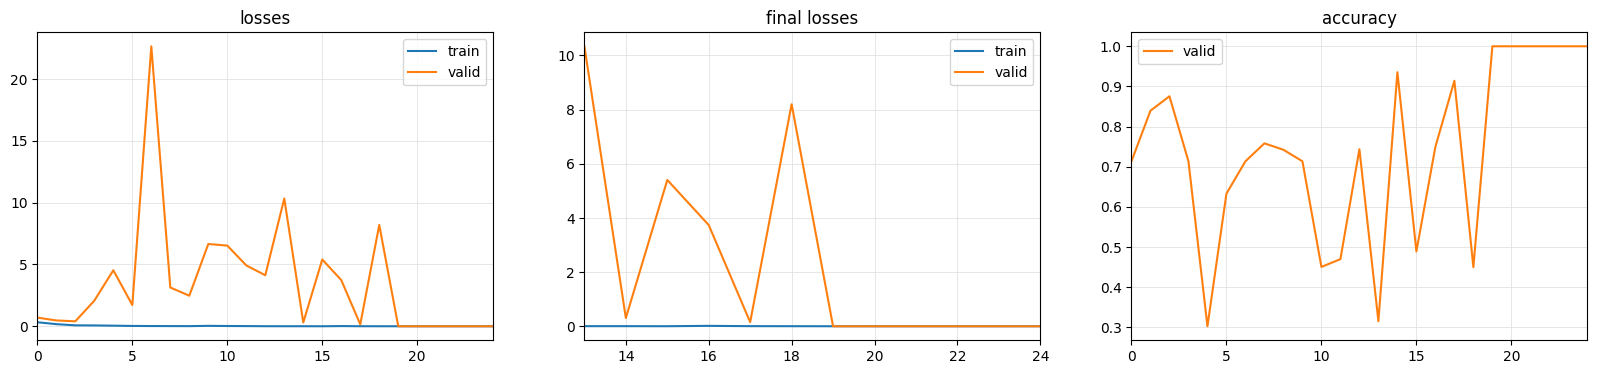

stock_group 2


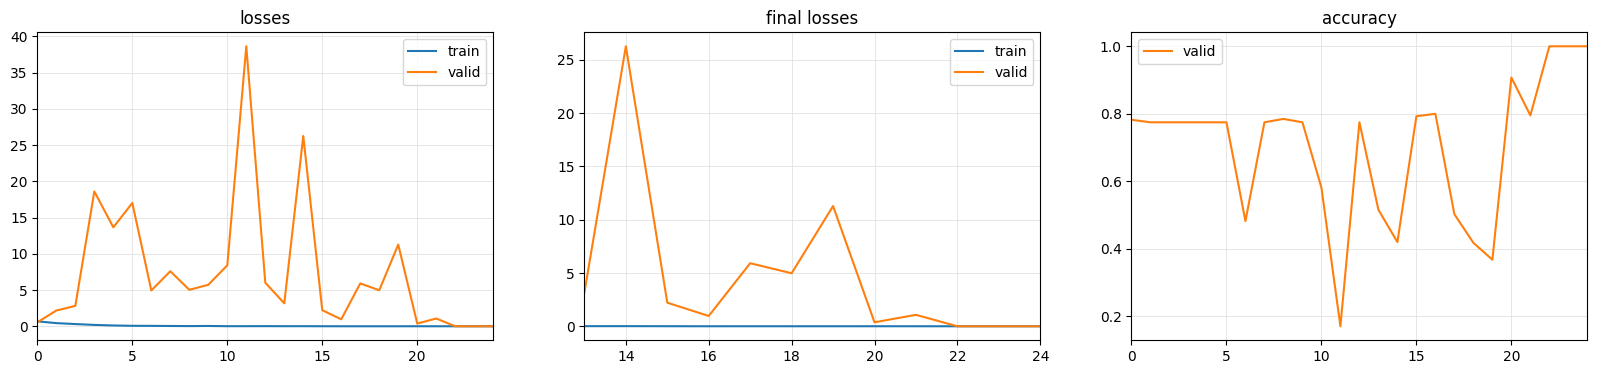

stock_group 3


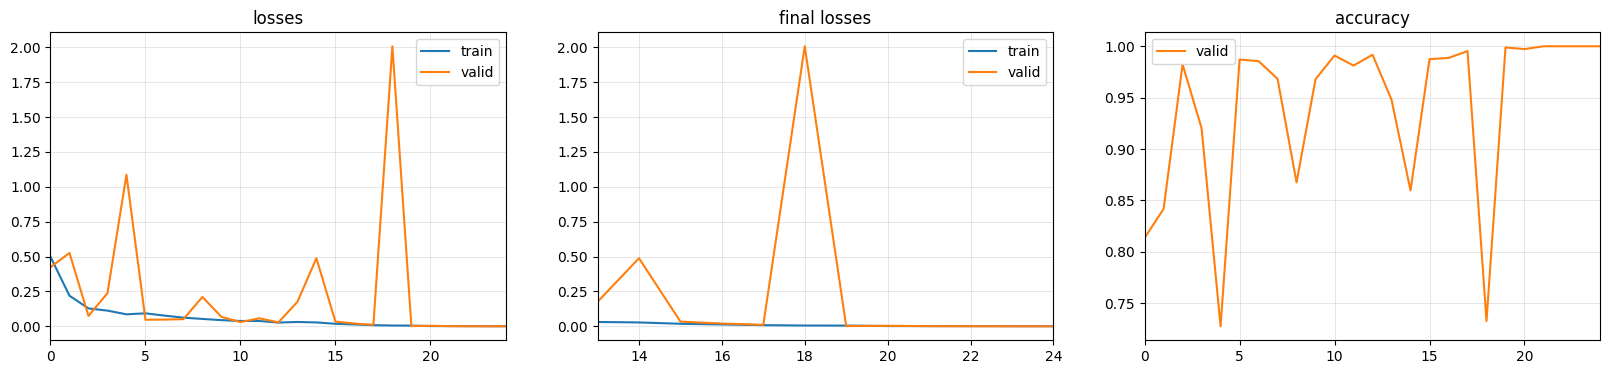

stock_group 4


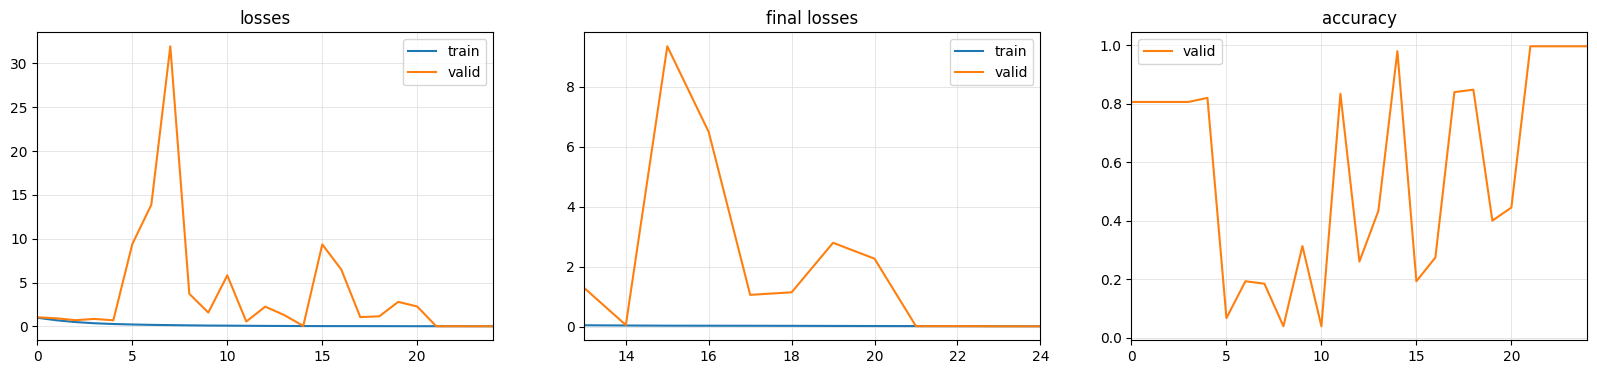

stock_group 5


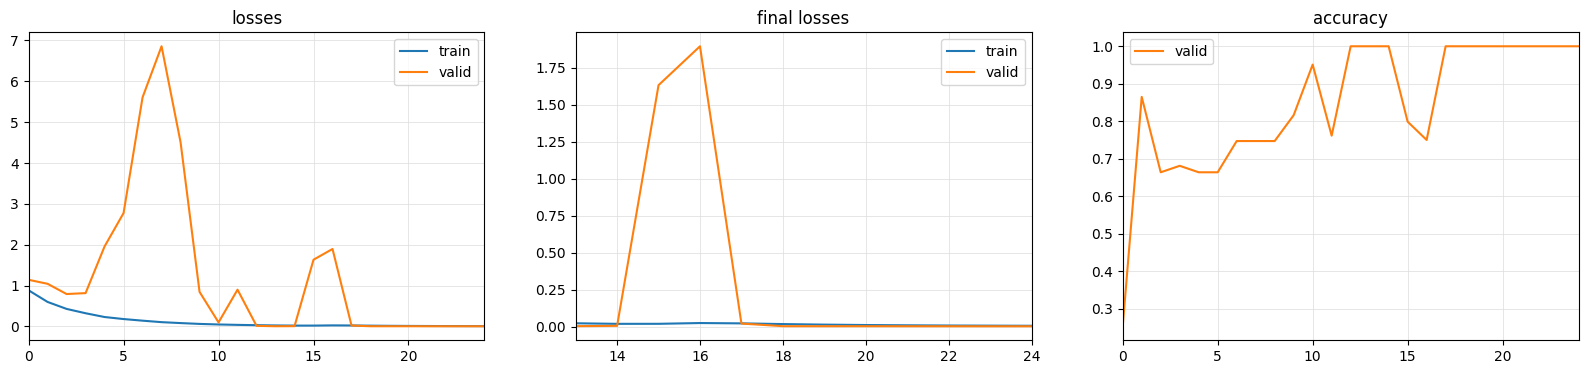

In [74]:
for i in range(stock_group_num):
    print('stock_group',i)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length(data,24)
        label=np.full(len(process_data), j)
        X.extend([p.transpose() for p in process_data])
        y=np.concatenate((y, label), axis=0)
    X=np.array(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=accuracy)
    learn.fit_one_cycle(25, lr_max=1e-3)
    learn.plot_metrics()
    learn.save_all(path='export', dls_fname='dls_'+str(i)+'_'+str(j), model_fname='model_'+str(i)+'_'+str(j), learner_fname='learner_'+str(i)+'_'+str(j))
#     display(type(X_train),X_train.shape)

# Key takeaway

InceptionTime can do the job

In [50]:
X, y, splits = get_classification_data('LSST', split_data=False)

In [53]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize()
dls = get_ts_dls(X, new_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

NameError: name 'new_y' is not defined

In [47]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        std=data_seg.adj.std()
        std_list.append(std)
    return std_list

In [ ]:
batch_tfms = TSStandardize(by_sample=True)
mv_clf = TSClassifier(X, y, splits=splits, path='models', arch=InceptionTimePlus, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
mv_clf.fit_one_cycle(10, 1e-2)
mv_clf.export("mv_clf.pkl")

## inference

## inference